In [64]:
import sys
!{sys.executable} -m pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 7.7 MB/s eta 0:00:0000:01


In [57]:
# Import the required modules
import glob
import time
import os
from collections import defaultdict
import fdsreader as fds
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import solve_ivp
from matplotlib import cm
from itertools import groupby, product
from scipy.spatial.distance import cdist

In [3]:

class windODE:
    def __init__(
            self,
            directory,
            fds_input_location,
            t_span,
            numberStreakLines
    ):
        """

        :param directory: location of the fds output files
        :param fds_input_location: location of the fds input file
        :param t_span: time frame for ODE to run over

        :vars self.sim: fdsreader object
        :vars self.fds_input_location: fds_input_location
        :vars self.t_span: t_span
        :vars self.__directory: directory
        :vars self.__qFiles: list of all plot 3d output files
        :vars self.__timeList: list of all plot 3d time dumps
        :vars self.__voxalSize: resolution of each voxal
        :vars self.__maxVelocity: maximum velocity of any particle in the streamlines
        :vars self.startingpoints: list of all starting points to be used in the ODE

        """

        self.sim = fds.Simulation(directory)
        self.fds_input_location = fds_input_location
        self.t_span = t_span
        self.__numberOfStreakLines = numberStreakLines
        self.__directory = directory
        self.__qFiles = glob.glob(directory + "*.q")
        self.__timeList = np.array(self.sim.data_3d.times)
        self.__voxalSize = {}
        self.__maxVelocity = 0.0
        self.__maxRe = 0.0
        self.__REDict=defaultdict(lambda : [])
        self.startingpoints = []
        self.__meshBounds = self.sim.meshes[0]
        self.__meshExtent = self.sim.meshes[0].extent

        self.getVoxalSize()

    def getVoxalSize(self):
        """
        Calculates voxal size
        :return:
        """

        self.__voxalSize["vx"] = (self.__meshExtent.x_end - self.__meshExtent.x_start) / (
                self.__meshBounds.dimension["x"] - 1
        )
        self.__voxalSize["vz"] = (self.__meshExtent.z_end - self.__meshExtent.z_start) / (
                self.__meshBounds.dimension["z"] - 1
        )
        self.__voxalSize["vy"] = (self.__meshExtent.y_end - self.__meshExtent.y_start) / (
                self.__meshBounds.dimension["y"] - 1
        )
        return self

    def getPositionFromIndex(self,x):
        x_index = x[0]
        y_index = x[1]
        z_index = x[2]
        x_position = self.__meshExtent.x_start + x_index*self.__voxalSize["vx"]
        y_position = self.__meshExtent.y_start + y_index*self.__voxalSize["vy"]
        z_position = self.__meshExtent.z_start + z_index*self.__voxalSize["vz"]
        return [x_position,y_position,z_position]

    def getStartingPoints(self):

        """
        Creates a list of points  on the outer most voxals of OBSTS, one point per voxal
        :var X_Min_Value center point of minimum x voxal
        :var X_Max_Value center point of maximum x voxal
        :var Y_Min_Value center point of minimum y voxal
        :var Y_Max_Value center point of maximum y voxal

        :return:
        """
        X_Min_Value = (
                self.__meshExtent.x_start + self.__voxalSize["vx"] / 2.0
        )
        X_Max_Value = (
                self.__meshExtent.x_end - self.__voxalSize["vx"] / 2.0
        )
        Y_Min_Value = (
                self.__meshExtent.y_start + self.__voxalSize["vy"] / 2.0
        )
        Y_Max_Value = (
                self.__meshExtent.y_end - self.__voxalSize["vy"] / 2.0
        )
        with open(self.fds_input_location) as f:
            lines = f.readlines()

        lineCounter = 0
        while lineCounter < len(lines):
            current_line = lines[lineCounter]
            if current_line == "\n":
                lineCounter += 1
                continue
            while "/" not in lines[lineCounter]:
                lineCounter += 1
                current_line = current_line + lines[lineCounter]

            lineCounter += 1
            if "&OBST" not in current_line:
                continue
            mesh_line = current_line.replace("/", "").replace("\n", "")
            XB = [float(point) for point in mesh_line.split("XB=")[1].split(",")[:6]]

            if XB[0] <= X_Min_Value <= XB[1]:
                self.startingPointsRibbon(
                    [XB[0], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[0], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[1] - XB[0]) / self.__voxalSize["vx"]),
                )

            if XB[0] <= X_Max_Value <= XB[1]:
                self.startingPointsRibbon(
                    [XB[1], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[1] - XB[0]) / self.__voxalSize["vx"]),
                )
            if XB[2] <= Y_Min_Value <= XB[3]:
                self.startingPointsRibbon(
                    [XB[0], XB[2], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[2], XB[5] + self.__voxalSize["vz"]],
                    int((XB[3] - XB[2]) / self.__voxalSize["vy"]),
                )
            if XB[2] <= Y_Max_Value <= XB[3]:
                self.startingPointsRibbon(
                    [XB[0], XB[3], XB[5] + self.__voxalSize["vz"]],
                    [XB[1], XB[3], XB[5] + self.__voxalSize["vz"]],
                    int((XB[3] - XB[2]) / self.__voxalSize["vy"]),
                )

        return self

    def filterOutStreamsByLength(self):
        """
        This function removes all streamlines that total distance traveled is below a desired length.
        :return:
        """
        self.filteredTImeResults = {}

        self.distanceofWindStreams_index = defaultdict(lambda: [])
        allData = self.timeReasults
        for time in allData.keys():

            data = allData[time]
            numberofWindstreams = len(data)
            lengthofWindStreams = [len(x["y"][0]) for x in data]
            print(numberofWindstreams)
            print(lengthofWindStreams)
            for i in range(numberofWindstreams):
                distanceofWindStream = 0
                for j in range(1, len(data[i]["y"][0])):
                    point1 = np.array(
                        (
                            data[i]["y"][0][j - 1],
                            data[i]["y"][1][j - 1],
                            data[i]["y"][2][j - 1],
                        )
                    )
                    point2 = np.array(
                        (data[i]["y"][0][j], data[i]["y"][1][j], data[i]["y"][2][j])
                    )
                    p1_p2_distance = np.linalg.norm(point1 - point2)
                    distanceofWindStream += p1_p2_distance

                if distanceofWindStream > np.min(list(self.__voxalSize.values())) * 2.0:
                    self.distanceofWindStreams_index[time].append(i)

    def startingPointsRibbon(self, starting_pont, ending_point, number_of_points):
        x_ = np.linspace(starting_pont[0], ending_point[0], number_of_points)
        y_ = np.linspace(starting_pont[1], ending_point[1], number_of_points)
        z_ = np.linspace(starting_pont[2], ending_point[2], number_of_points)
        points = np.stack((x_.flatten(), y_.flatten(), z_.flatten()), axis=1)

        self.startingpoints.extend(points)
        return self

    def runODE(self,time_step_index,reverse_integration=False):
        t_span = [
            min(self.__timeList[time_step_index:]),
            max(self.__timeList[time_step_index:]),
        ]
        current_results=[]

        if reverse_integration:
            t_span[1] = 0.0

        for startCounter in range(len(self.startingpoints)):
            y0 = self.startingpoints[startCounter]

            result_solve_ivp = solve_ivp(
                self.get_velocity, t_span, y0,
                # rtol=1E-4, atol=1E-6,
            )
            result_with_velocity = self.addVelocity(result_solve_ivp)
            current_result_max_vel = np.max(result_with_velocity["velocity"])
            if self.__maxVelocity < current_result_max_vel:
                print(
                    f"new max Velocity {current_result_max_vel} changed from {self.__maxVelocity}"
                )
                self.__maxVelocity = current_result_max_vel

            result_with_re = self.addReynoldsNumber(result_with_velocity)
            current_result_max_re = np.max(result_with_re["re"])
            self.__REDict[self.__timeList[time_step_index]].append(current_result_max_re)
            if self.__maxRe < current_result_max_re:
                print(
                    f"new max RE {current_result_max_re} changed from {self.__maxRe}"
                )
                self.__maxRe = current_result_max_re
            current_results.append(result_with_re)
        return current_results

    def StartODE(self, reverse_integration=True):

        self.timeReasults = {}
        for t_start in self.__timeList:
            if t_start > self.t_span[1] or t_start < self.t_span[0]:
                continue

            time_step_index = self.__GetClosestTimeStepIndex(t_start)

            all_results=self.runODE(time_step_index)
            if reverse_integration:
                backward = self.runODE(time_step_index,True)
                all_results= self.combineODEFrames(all_results,backward)
            self.timeReasults[t_start] = all_results

        return self

    def combineODEFrames(self, all_forward_data,all_backwards_data):
        return_values = all_backwards_data
        for i in range(len(all_backwards_data)):
            backwards_data = all_backwards_data[i]
            forward_data = all_forward_data[i]
            return_values[i]['t'] = backwards_data['t'][::-1]
            return_values[i]['y'][0] = backwards_data['y'][0][::-1]
            return_values[i]['y'][1] = backwards_data['y'][1][::-1]
            return_values[i]['y'][2] = backwards_data['y'][2][::-1]
            return_values[i]['velocity'] = backwards_data['velocity'][::-1] * -1
            return_values[i]['re'] = backwards_data['re'][::-1]


            return_values[i]['t']= np.concatenate((backwards_data['t'], forward_data['t'][1:]))

            y_=[np.concatenate((backwards_data['y'][0],forward_data['y'][0][1:])),
              np.concatenate((backwards_data['y'][1],forward_data['y'][1][1:])),
              np.concatenate((backwards_data['y'][2],forward_data['y'][2][1:]))]
            return_values[i]['y']=y_
            return_values[i]['velocity']=np.concatenate((backwards_data['velocity'],forward_data['velocity'][1:]))

            return_values[i]['re']=np.concatenate((backwards_data['re'], forward_data['re'][1:]))

        return return_values


    def write2bin(self, desired_directory, file_name_prefix):
        fileName = os.path.join(desired_directory, file_name_prefix)
        allData = self.timeReasults
        maxVel = self.__maxVelocity
        print(f"Max {maxVel}")
        for time in allData.keys():
            data = allData[time]
            numberofWindstreams = len(data)
            lengthofWindStreams = [len(x["y"][0]) for x in data]
            print(numberofWindstreams)
            print(lengthofWindStreams)
            time_string = f"{time}".split(".")[1]
            with open(f"{fileName}_{int(time)}_{time_string}.binwind", "wb") as outfile:

                np.ndarray.tofile(np.array([maxVel], dtype=np.float32), outfile)
                np.ndarray.tofile(np.array([numberofWindstreams], dtype=int), outfile)
                np.ndarray.tofile(np.array(lengthofWindStreams, dtype=int), outfile)

                for i in range(numberofWindstreams):
                    currentStream = []
                    for j in range(len(data[i]["y"][0])):
                        currentStream.append(
                            [
                                data[i]["t"][j],
                                data[i]["velocity"][j],
                                data[i]["y"][0][j],
                                data[i]["y"][1][j],
                                data[i]["y"][2][j],
                            ]
                        )

                    np.ndarray.tofile(
                        np.array(currentStream, dtype=np.float32), outfile
                    )
                print(fileName, "saved")
        return self

    def get_velocity(self, t, x):

        counter = self.__GetClosestTimeStepIndex(t)
        plt_3d_data = self.sim.data_3d[counter]

        mesh = self.sim.meshes[0]
        # Select a quantity
        uvel_idx = plt_3d_data.get_quantity_index("U-VEL")
        vvel_idx = plt_3d_data.get_quantity_index("V-VEL")
        wvel_idx = plt_3d_data.get_quantity_index("W-VEL")
        index_values = self.get_index_values(x)
        u_vel_data = plt_3d_data[mesh].data[:, :, :, uvel_idx]
        u_velocity = u_vel_data[index_values[0], index_values[1], index_values[2]]
        v_vel_data = plt_3d_data[mesh].data[:, :, :, vvel_idx]
        v_velocity = v_vel_data[index_values[0], index_values[1], index_values[2]]
        w_vel_data = plt_3d_data[mesh].data[:, :, :, wvel_idx]
        w_velocity = w_vel_data[index_values[0], index_values[1], index_values[2]]

        return np.array([u_velocity, v_velocity, w_velocity])

    def get_index_values(self, x):
        x_index = (x[0] - self.__meshExtent.x_start) / self.__voxalSize["vx"]
        if 0 > x_index or x_index > self.__meshBounds.dimension["x"]:
            return np.array([0, 0, 0], dtype=int)
        y_index = (x[1] - self.__meshExtent.y_start) / self.__voxalSize["vy"]
        if 0 > y_index or y_index > self.__meshBounds.dimension["y"]:
            return np.array([0, 0, 0], dtype=int)
        z_index = (x[2] - self.__meshExtent.z_start) / self.__voxalSize["vz"]
        if 0 > z_index or z_index > self.__meshBounds.dimension["z"]:
            return np.array([0, 0, 0], dtype=int)
        return np.array([x_index, y_index, z_index], dtype=int)

    def addReynoldsNumber(self, oneDataSet):
        """

        :param oneDataSet:
        :return: same dataset with added velocity information
        """

        allRe = []  # all particles start at 0 velocity

        allTimes = oneDataSet["t"]
        allPositions = oneDataSet["y"]
        for i in range(len(allPositions[0])):
            currentPosition = np.array(
                [allPositions[0][i], allPositions[1][i], allPositions[2][i]]
            )

            currentTime = allTimes[i]
            allRe.append(self.__GetReynoldsNumber(currentPosition, currentTime))

        oneDataSet["re"] = np.array(allRe)
        return oneDataSet

    def addVelocity(self, oneDataSet):
        """

        :param oneDataSet:
        :return: same dataset with added velocity information
        """

        allSpeeds = [0.0]  # all particles start at 0 velocity

        allTimes = oneDataSet["t"]
        allPositions = oneDataSet["y"]
        previousPosition = np.array(
            [allPositions[0][0], allPositions[1][0], allPositions[2][0]]
        )
        for i in range(1, len(allPositions[0])):
            currentPosition = np.array(
                [allPositions[0][i], allPositions[1][i], allPositions[2][i]]
            )

            deltaTime = allTimes[i] - allTimes[i - 1]
            squared_dist = np.sum((currentPosition - previousPosition) ** 2, axis=0)
            dist = np.sqrt(squared_dist)
            if dist ==0.0 or deltaTime ==0.0:
                speed=0.0
            else:
                speed = dist / deltaTime
            allSpeeds.append(speed)
            previousPosition = currentPosition

        oneDataSet["velocity"] = np.array(allSpeeds)
        return oneDataSet

    def drawPlot(self):
        for time in self.distanceofWindStreams_index.keys():
            data = self.timeReasults[time]
            maxRE= np.max(np.array(self.__REDict[time]))
            fig = plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(1, 1, 1, projection="3d")
            for i in self.distanceofWindStreams_index[time]:

                x = data[i]["y"][0][:]
                y = data[i]["y"][1][:]
                z = data[i]["y"][2][:]
                re = data[i]["re"][:]

                temp =np.max(re)/maxRE
                ax.plot(x, y, z,  c=cm.viridis(temp))
            plt.show()


    def __GetClosestTimeStepIndex(self, t):
        closest_timeStep_value = min(self.__timeList, key=lambda x: abs(x - t))
        closest_timeStep_index = np.where(self.__timeList == closest_timeStep_value)[0][0]
        return int(closest_timeStep_index)

    def __GetReynoldsMatrix(self, t):
        time_step_index = self.__GetClosestTimeStepIndex(t)
        plt_3d_data = self.sim.data_3d[time_step_index]

        mesh = self.sim.meshes[0]
        # Select a quantity
        try:
            dxeta_idx = plt_3d_data.get_quantity_index("dx/eta")
        except:
            print("dx/eta plot 3d data ot found ")
            return []

        re_data = plt_3d_data[mesh].data[:, :, :, dxeta_idx]

        return re_data

    def __GetReynoldsNumber(self, x, t):
        re_data = self.__GetReynoldsMatrix(t)
        if len(re_data)==0:
            return

        index_values = self.get_index_values(x)
        re_value = re_data[index_values[0], index_values[1], index_values[2]]

        return re_value

    def EvaluateReynoldsValues(self):
        values = defaultdict(lambda : 0)
        for t in self.__timeList[3:10]:
            current_Re_values = self.__GetReynoldsMatrix(t)
            flatten_values =flatten_values_sorted  = np.array(current_Re_values,dtype=np.float64).flatten()
            flatten_values_sorted= list(np.sort(flatten_values_sorted))
            Re_percentile_min = np.percentile(flatten_values,86.5)
            ranking = {}
            for i in range(len(flatten_values_sorted)):
                ranking[flatten_values[i]]=i

            for i in range(current_Re_values.shape[0]):
                for j in range(current_Re_values.shape[1]):
                    for k in range(current_Re_values.shape[2]):
                        if current_Re_values[i,j,k] >=Re_percentile_min:
                            values[f"{i},{j},{k}"] += current_Re_values[i,j,k]

        print(np.max(list(values.values())))
        fig = plt.figure(figsize=(10, 7))
        ax = plt.axes(projection="3d")
        max_value = np.percentile(list(values.values()),70)
        x=[]
        y=[]
        z=[]
        c=[]
        for key in list(values.keys()):
            if values[key]< max_value:
                continue
            x_k,y_k,z_k = key.split(',')
            x.append(int(x_k))
            y.append(int(y_k))
            z.append(int(z_k))
            value = float(values[key])
            c.append(value)

        # Creating color map
        my_cmap = plt.get_cmap('viridis')

        scatter_plot=ax.scatter3D(x,y,z,c=c,cmap=my_cmap)

        plt.colorbar(scatter_plot)

        plt.show()

        highest_re_Points = []
        c_sorted = sorted(c)
        for i in range(len(c)):
            highest_re_Points.append(c.index(c_sorted[i]))

        fig = plt.figure(figsize=(10, 7))
        ax = plt.axes(projection="3d")
        x_1 = []
        y_1 = []
        z_1 = []
        c_1 = []
        for key in highest_re_Points[self.__numberOfStreakLines*-1:]:
            x_1.append(x[key])
            y_1.append(y[key])
            z_1.append(z[key])
            value = float(c[key])
            c_1.append(value)

        # Creating color map
        my_cmap = plt.get_cmap('viridis')
        scatter_plot = ax.scatter3D(x_1, y_1, z_1, c=c_1, cmap=my_cmap)
        plt.colorbar(scatter_plot)
        plt.show()

        points_of_interest_index = [ [x_1[i],y_1[i],z_1[i]] for i in range(len(x_1))]
        points_of_interest_position = [ self.getPositionFromIndex([x_1[i],y_1[i],z_1[i]]) for i in range(len(x_1))]
        for i in range(len(points_of_interest_position)):
            print(points_of_interest_index[i],points_of_interest_position[i])

        self.startingpoints.extend(points_of_interest_position)


    def getDataFromTime(self,t):
        if t in self.timeReasults.keys():
            return self.timeReasults[t]
        return []

    def getMaxRE(self):
        return self.__maxRe

    def getReynoldsMatrix(self,t):
        return self.__GetReynoldsMatrix(t)
    def getTimeList(self):
        return self.__timeList



In [4]:



fds_loc = "/home/trent/Trunk/Trunk/Trunk.fds"
dir = "/home/trent/Trunk/Fire"
# fds_loc = "/home/kl3pt0/Trunk/Trunk/Trunk.fds"
# dir = "/home/kl3pt0/Trunk/Fire"
#
# fds_loc = "E:\Trunk\Trunk\Trunk\Trunk.fds"
# dir = "E:\Trunk\Trunk\\temp\\"

t_span = [15,16]
start_time = time.perf_counter()
app = windODE(dir, fds_loc, t_span,100)
# app.EvaluateReynoldsValues()


# app.getStartingPoints()
# app.startingPointsRibbon([19, 1, 3.5], [1, 19, 3.5], 40)
# app.startingpoints = [[10,10,3]]
# app.StartODE(reverse_integration=True)
#
# app.filterOutStreamsByLength()
# app.write2bin("data","temp")

print(f"Total Time {time.perf_counter()-start_time:0.4f}")
# app.drawPlot()
print()

Total Time 0.0066



In [18]:
t_start = 0
t_end= 60

allTimelist = app.getTimeList()
filteredTimeList = allTimelist[allTimelist>=t_start]
filteredTimeList = filteredTimeList[filteredTimeList<=t_end]
testData = app.getReynoldsMatrix(filteredTimeList[0])
for i in range(1,len(filteredTimeList)):

    testData = testData + app.getReynoldsMatrix(filteredTimeList[i])
testData = testData/len(filteredTimeList)


[ 0.5   1.    1.51  2.    2.5   3.    3.51  4.1   4.5   5.    5.5   6.
  6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5  12.
 12.5  13.   13.51 14.1  14.5  15.   15.5  16.   16.5  17.   17.5  18.
 18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5  24.
 24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5  30.
 30.5  31.   31.5  32.   32.51 33.   33.5  34.   34.5  35.   35.5  36.
 36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5  42.1
 42.5  43.   43.5  44.   44.51 45.   45.5  46.   46.5  47.   47.5  48.
 48.5  49.   49.5  50.   50.51 51.   51.5  52.   52.5  53.1  53.5  54.
 54.5  55.   55.5  56.1  56.5  57.   57.51 58.   58.5  59.1  59.5  60.  ]


(101, 101, 101)
Min non Zero Value 44.19196764628092
Standard Dev 157.44676463863013
Mean 666.4256167810765
3 sigma 1138.7659106969668
[67.00198542435963 158.24205653667448 244.92012409337357
 363.53221653938294 454.77228765169775 536.8883516527811 632.6904263207117
 710.2444867661793 947.4686716581979 1034.146739214897 1129.9488138828278
 1207.5028743282953 1275.9329276625315 1353.4869881079992
 1444.727059220314 1572.4631587775548 1645.4552156674067
 1754.9433010021844]
[  5  25  44  70  90 108 129 146 198 217 238 255 270 287 307 335 351 375]


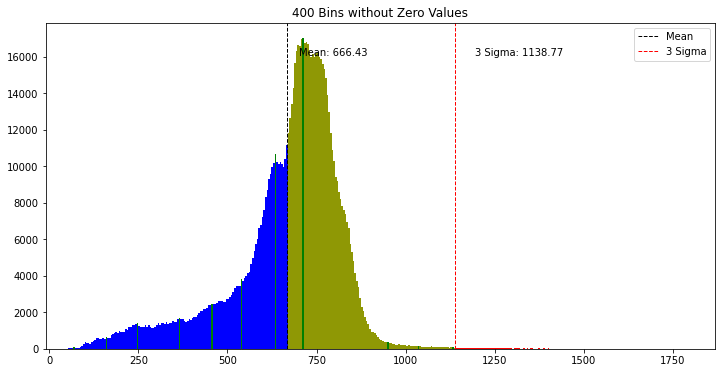

In [40]:
n_bins = 400

print(np.array(testData).shape)
testDataFlatten = np.array(testData).flatten()
testNoZero = testDataFlatten[testDataFlatten>0.0]

print(f"Min non Zero Value {np.min(testNoZero)}")

testMean = np.mean(testNoZero)
testStd = np.std(testNoZero)
testSig3 = testMean+ 3.0*testStd
print(f"Standard Dev {testStd}")
print(f"Mean {testMean}")
print(f"3 sigma {testSig3}")




fig, ax = plt.subplots(figsize=(12, 6))

plt.title(f"{n_bins} Bins without Zero Values")
plt.xlim([-10,np.max(testData)])

n,bins,patches=plt.hist(testNoZero, bins=n_bins)

peaks, _ = find_peaks(n,distance=15)
print(bins[peaks])
print(peaks)
plt.axvline(testMean, color='k', linestyle='dashed', linewidth=1, label="Mean")
plt.axvline(testSig2, color='r', linestyle='dashed', linewidth=1,label="3 Sigma")
min_ylim, max_ylim = plt.ylim()
plt.text(testMean*1.05, max_ylim*0.9, 'Mean: {:.2f}'.format(testMean))
plt.text((testSig3)*1.05, max_ylim*0.9, '3 Sigma: {:.2f}'.format(testSig3))
ax.legend()
for patch_i in range(len(patches)):

    patches[patch_i].set_fc("red")
    if bins[patch_i]<testSig2:
        patches[patch_i].set_fc("xkcd:baby poop green")
    if bins[patch_i]<testMean:
        patches[patch_i].set_fc("blue")
    if patch_i in peaks:
        patches[patch_i].set_fc("green")
    if bins[patch_i]>= testSig3:
            patches[patch_i].set_fc("red")
plt.show()




(101, 101, 101)
Length of points between 67.00198542435963 71.56398897997538 is 72.0


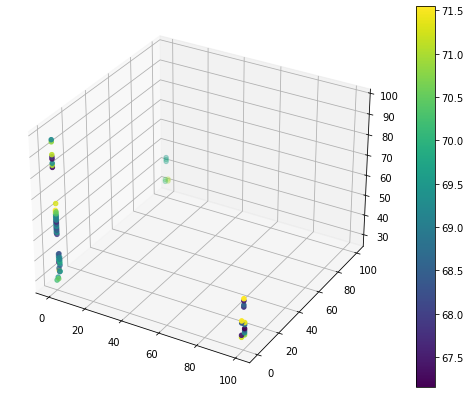

Length of points between 158.24205653667448 162.80406009229023 is 621.0


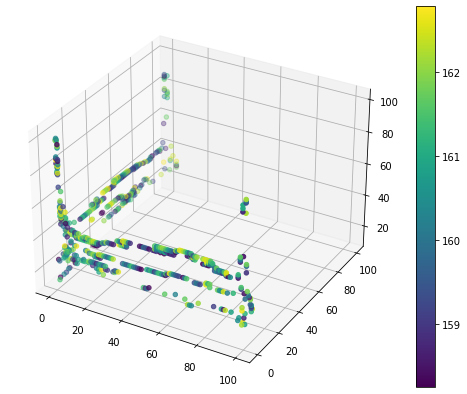

Length of points between 244.92012409337357 249.48212764898932 is 1396.0


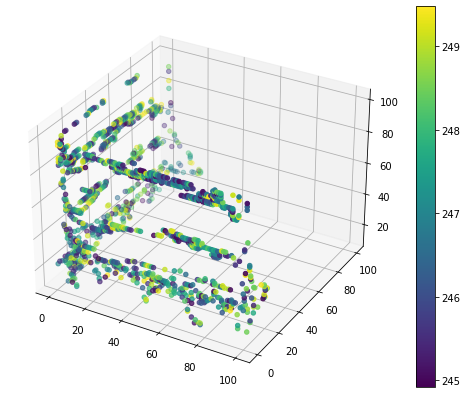

Length of points between 363.53221653938294 368.09422009499866 is 1681.0


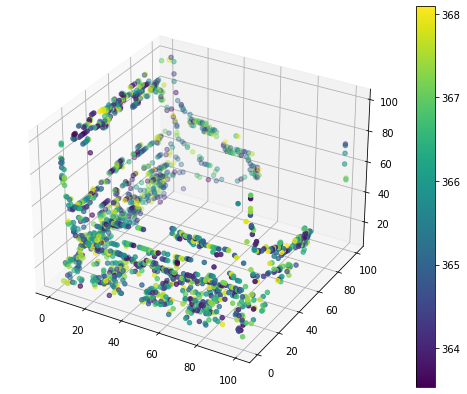

Length of points between 454.77228765169775 459.3342912073135 is 2440.0


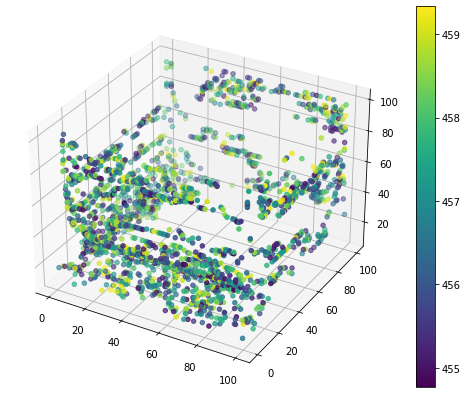

Length of points between 536.8883516527811 541.4503552083969 is 3807.0


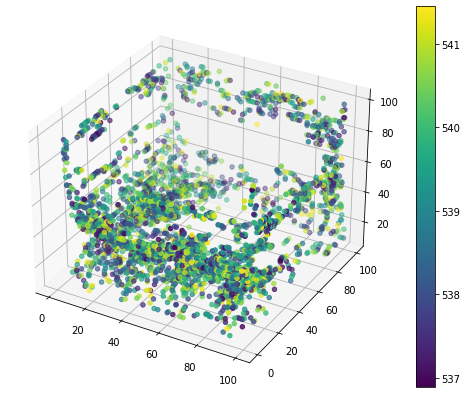

Length of points between 632.6904263207117 637.2524298763274 is 10660.0


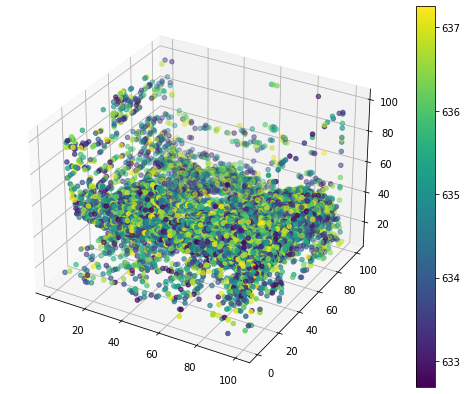

Length of points between 710.2444867661793 714.8064903217951 is 17023.0


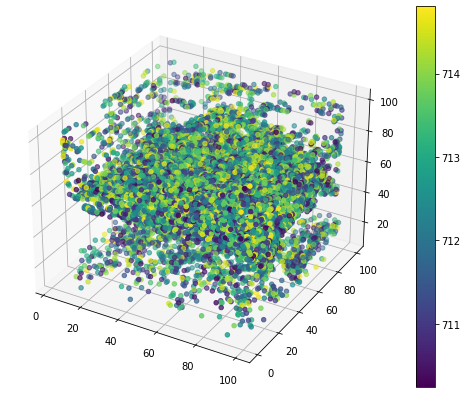

Length of points between 947.4686716581979 952.0306752138137 is 364.0


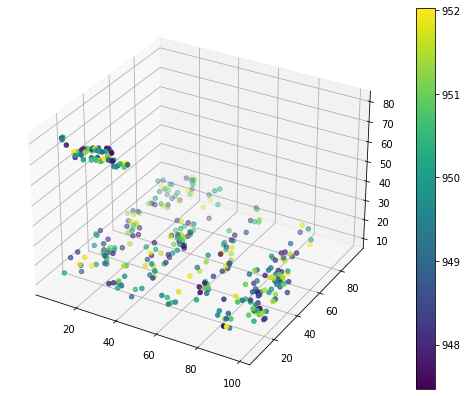

Length of points between 1034.146739214897 1038.7087427705128 is 161.0


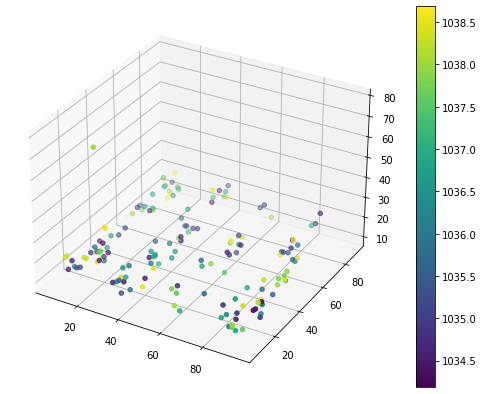

Length of points between 1129.9488138828278 1134.5108174384434 is 93.0


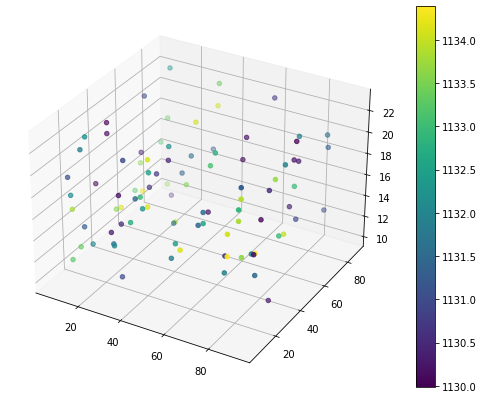

Length of points between 1207.5028743282953 1212.064877883911 is 59.0


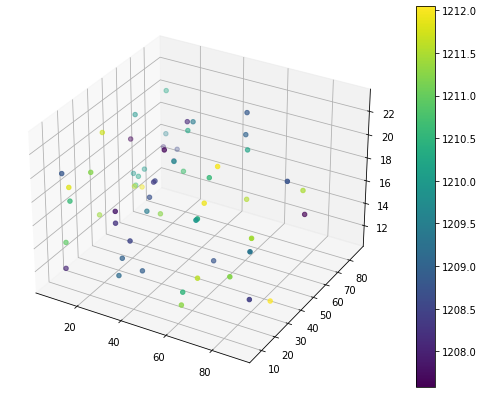

Length of points between 1275.9329276625315 1280.4949312181473 is 34.0


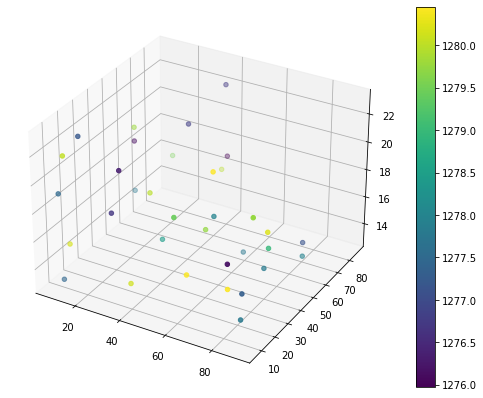

Length of points between 1353.4869881079992 1358.048991663615 is 20.0


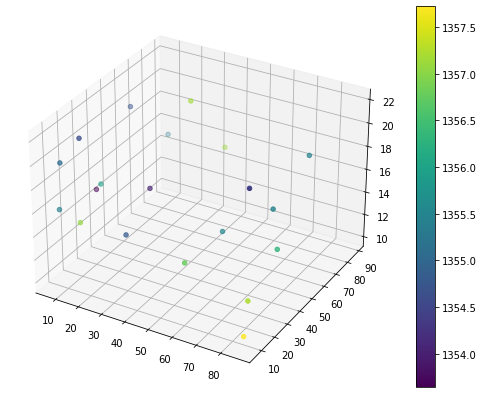

Length of points between 1444.727059220314 1449.2890627759298 is 15.0


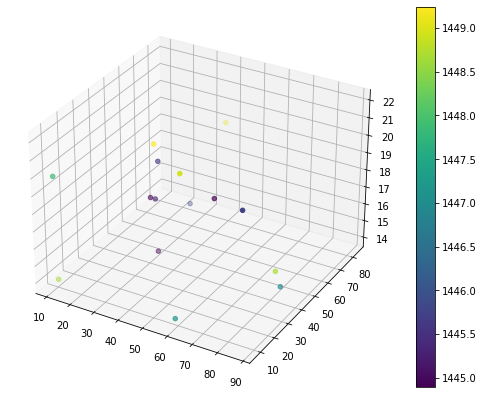

Length of points between 1572.4631587775548 1577.0251623331706 is 6.0


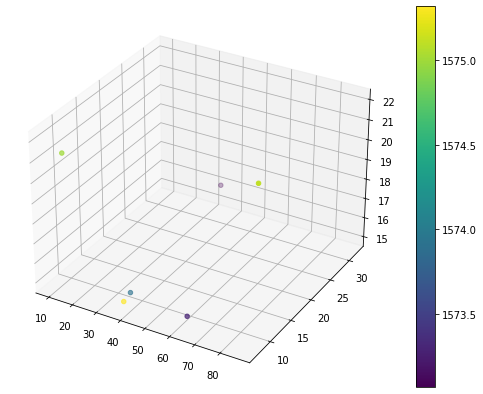

Length of points between 1645.4552156674067 1650.0172192230223 is 3.0


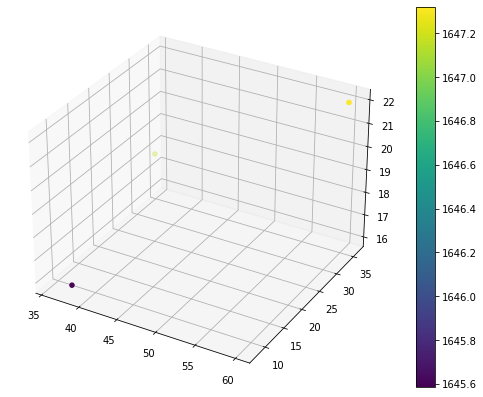

Length of points between 1754.9433010021844 1759.5053045578002 is 2.0


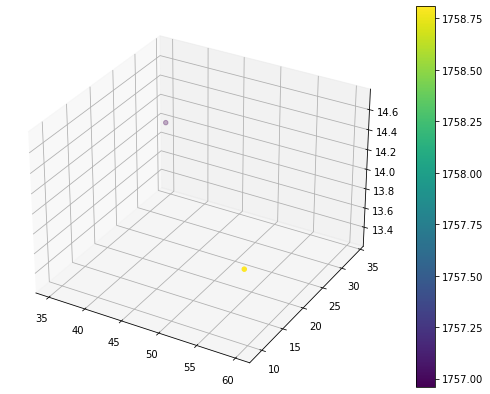

In [30]:
testData = np.array(testData)
print(testData.shape)
for peaks_i in peaks:
    print(f"Length of points between {bins[peaks_i]} {bins[peaks_i+1]} is {n[peaks_i]}")
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection="3d")
    x_1 = []
    y_1 = []
    z_1 = []
    c_1 = []
    for x_i in range(testData.shape[0]):
        for y_i in range(testData.shape[1]):
            for z_i in range(testData.shape[2]):
                if bins[peaks_i]<testData[x_i,y_i,z_i]<bins[peaks_i+1]:

                    x_1.append(x_i)
                    y_1.append(y_i)
                    z_1.append(z_i)
                    c_1.append(testData[x_i,y_i,z_i])

    # Creating color map
    my_cmap = plt.get_cmap('viridis')
    scatter_plot = ax.scatter3D(x_1, y_1, z_1, c=c_1, cmap=my_cmap)
    plt.colorbar(scatter_plot)
    plt.show()


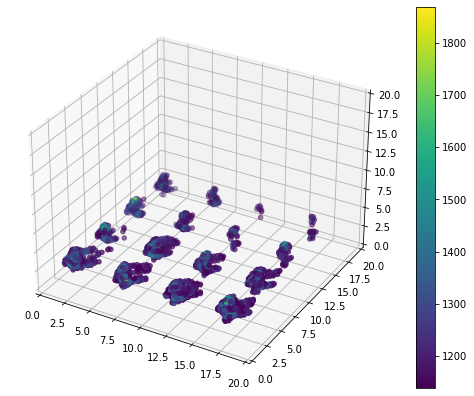

2235


In [119]:

fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
positions = []
x_1 = []
y_1 = []
z_1 = []
c_1 = []
counter = 0
for x_i in range(testData.shape[0]):
    for y_i in range(testData.shape[1]):
        for z_i in range(testData.shape[2]):
            if testData[x_i,y_i,z_i]>=testSig3:
                position =app.getPositionFromIndex([x_i,y_i,z_i])
                x_1.append(position[0])
                y_1.append(position[1])
                z_1.append(position[2])
                c_1.append(testData[x_i,y_i,z_i])
                positions.append(position)
                counter +=1

# Creating color map
my_cmap = plt.get_cmap('viridis')
scatter_plot = ax.scatter3D(x_1, y_1, z_1, c=c_1, cmap=my_cmap)
ax.set_zlim(0,20)
ax.set_ylim(0,20)
ax.set_xlim(0,20)
plt.colorbar(scatter_plot)
plt.show()
print(counter)

In [120]:
app.startingpoints = positions
app.StartODE(reverse_integration=True)

app.filterOutStreamsByLength()

print(f"Total Time {time.perf_counter()-start_time:0.4f}")
app.drawPlot()
print()

[0.02940893 0.02940893 0.02940893 0.02940893 0.02940893 0.02940893
 0.02940893 0.02940893 0.02967266 0.03016072 0.03204252 0.04114484
 0.06068637 0.10146255 0.64049174 0.94397896 1.094031   1.2       ]
[ 1.2         1.30953318  1.39284506  1.49935867  1.57686982  1.68696513
  1.90912223  2.21709858  2.44187346  2.66915583  2.91407574  3.10592496
  3.39844583  3.69920714  3.97201207  4.14868154  4.21444453  4.37182599
  4.7118414   5.18892033  5.3410153   5.57371387  5.73390866  5.92649418
  6.11637348  6.37545541  6.78658277  7.0817338   7.75281349  8.71441166
  9.48260434 10.15974168 11.00680768 11.62137678 12.36131428 13.10619731
 14.01985676 14.43757122 14.43757122 14.43757122 14.43757122 14.43757122]
[-3.14391551e-04 -3.14391551e-04 -3.14391551e-04 -3.14391551e-04
 -3.14391551e-04 -3.14391551e-04 -3.14391551e-04  7.45695604e-05
  8.79349032e-04  4.11886389e-03  1.33670632e-02  4.01841918e-02
  4.30473531e-01  7.01411730e-01  9.28723187e-01  1.10805752e+00
  1.20000000e+00]
[ 1.2   

[-7.00266127e-05 -7.00266127e-05 -7.00266127e-05 -7.00266127e-05
 -7.00266127e-05 -7.00266127e-05 -7.00266127e-05 -7.00266127e-05
  1.41275250e-04  1.58969772e-03  5.44261582e-03  2.43366532e-02
  8.45521035e-02  2.09981984e-01  4.20376321e-01  6.11931079e-01
  8.92521450e-01  1.23318204e+00  1.49331059e+00  1.52399869e+00
  1.60000000e+00]
[ 1.6         1.65889001  1.99932602  2.27862621  2.55216388  2.93849341
  3.1140352   3.35598539  3.60557243  3.7660242   3.74286755  3.80125865
  3.82807011  4.08637361  4.46042481  4.95645469  5.05473939  5.27971049
  5.81775582  6.52468938  7.11098823  7.57502263  8.0419215   8.71797886
  9.26513822  9.71632621 10.20933303 10.80855791 11.27842161 11.92244956
 12.43691802 12.93903883 13.1635886  13.62508654 13.93707241 14.14475499
 14.39757539 14.45336795 14.64350778 14.64350778 14.64350778 14.64350778
 14.64350778]
[-2.65765935e-04 -2.65765935e-04 -2.65765935e-04 -2.65765935e-04
 -2.65765935e-04 -2.65765935e-04 -2.65765935e-04  1.15948725e-04
  

[-2.60558942e-04 -2.60558942e-04 -2.60558942e-04 -2.60558942e-04
 -2.60558942e-04 -2.60558942e-04 -2.60558942e-04  6.28617851e-05
  6.61365526e-04  3.28747279e-03  2.20293568e-02  8.36125021e-02
  2.77223106e-01  6.94425109e-01  1.13302032e+00  1.39936778e+00
  1.63823491e+00  1.80000000e+00]
[1.8        1.9949647  2.09814012 2.18577658 2.28766882 2.34700995
 2.48438688 2.61227005 2.7959472  2.95124488 3.02467459 3.0612845
 3.1836176  3.24364519 3.28453534 3.40583426 3.56914919 3.63660241
 3.62730429 3.66447899 3.73957716 3.97776019 4.10845264 4.21302571
 4.35433946 4.53583587 4.90173574 5.30406779 5.68754391 6.01128337
 6.30877436 6.81941492 7.14850494 7.50604058 7.9515541  7.98347344
 7.98347344 7.98347344 7.98347344 7.98347344]
[-1.57299098e-05 -1.57299098e-05 -1.57299098e-05 -1.57299098e-05
 -1.57299098e-05 -1.57299098e-05 -1.57299098e-05  3.02825447e-05
  5.35104903e-04  2.58347648e-03  1.06375622e-02  3.47892186e-02
  1.06201893e-01  4.57359408e-01  1.00989834e+00  1.42941119e+00

[-3.13880290e-05 -3.13880290e-05 -3.13880290e-05 -3.13880290e-05
 -3.13880290e-05 -3.13880290e-05 -3.13880290e-05  3.56686188e-04
  1.94093014e-03  1.14017114e-02  6.00192856e-02  2.18144181e-01
  6.86620970e-01  1.28225148e+00  1.64826649e+00  1.84327511e+00
  2.00000000e+00]
[2.         2.21408558 2.40192987 2.5675775  2.6571744  2.76812741
 2.9130213  3.02688206 3.21528898 3.36979964 3.74659079 3.9198872
 4.13750937 4.48438036 4.79144036 5.03582451 5.14756791 5.29141916
 5.34839438 5.34839438 5.34839438 5.34839438 5.34839438]
[-7.66990070e-05 -7.66990070e-05 -7.66990070e-05 -7.66990070e-05
 -7.66990070e-05 -7.66990070e-05 -7.66990070e-05  2.02833728e-04
  1.89242106e-03  6.49807329e-03  1.94276630e-02  1.08874652e-01
  2.99790965e-01  7.19827441e-01  1.15374481e+00  1.48390401e+00
  1.80056735e+00  2.00000000e+00]
[2.         2.29083687 2.55909877 2.82269493 3.01335863 3.17555805
 3.34928954 3.56138247 3.67728388 3.75657292 4.01765819 4.17321658
 4.16749834 4.1617801  4.13702689 4.2

[-6.53164898e-05 -6.53164898e-05 -6.53164898e-05 -6.53164898e-05
 -6.53164898e-05 -6.53164898e-05 -6.53164898e-05  5.73006631e-06
  7.85212282e-04  3.15609314e-03  1.24602989e-02  4.03417569e-02
  1.68094449e-01  4.50203662e-01  8.33168341e-01  1.23908627e+00
  1.83972336e+00  2.14702805e+00  2.40000000e+00]
[ 2.4         2.65453557  3.0908062   3.48806493  3.87933415  4.33058835
  4.69321073  5.01495274  5.32110062  5.79639156  6.15295165  6.39797675
  6.73008333  7.36428511  7.80503082  7.87613524  7.96456833  8.37564569
  8.71873555  8.85311166  8.88692711  9.00331323  9.20143701  9.28083087
  9.51634473  9.97047198 10.3529082  10.59761127 10.88943414 11.02300127
 11.2298333  11.45848634 12.14332724 12.43136595 12.66021031 12.66021031
 12.66021031 12.66021031 12.66021031]
[-2.38931807e-05 -2.38931807e-05 -2.38931807e-05 -2.38931807e-05
 -2.38931807e-05 -2.38931807e-05 -2.38931807e-05  2.25296757e-05
  5.31854729e-04  2.61236387e-03  1.24200737e-02  4.27456895e-02
  1.33775840e-01  6

[0.67870848 0.67870848 0.67870848 0.67870848 0.67870848 0.67870848
 0.67870848 0.67870848 0.67886687 0.67992246 0.68278215 0.69077099
 0.71350082 0.78050884 0.84915633 1.33309567 1.65418772 1.88376708
 2.1161953  2.28864159 2.49663525 2.59272452 2.64481756 2.72950518
 2.77560796 2.93166516 2.94121721 2.97955935 3.        ]
[ 3.          3.17056331  3.3341536   3.46592534  3.7201003   3.94349337
  4.21094918  4.4267512   4.73731457  5.02998329  5.34797834  6.0270711
  7.03696431  7.98381163  9.02704076  9.99707878 10.70102755 11.26210949
 11.97522809 12.98816709 13.61587688 14.41749823 14.75053467 14.75053467
 14.75053467 14.75053467 14.75053467]
[2.75617939 2.75617939 2.75617939 2.75617939 2.82919391 2.88725269
 2.95013052 3.08852272 3.18746915 3.25258122 3.28098105 3.28816376
 3.29713137 3.2878913  3.27572278 3.18773246 3.22095372 3.18327182
 3.07335321 2.94188884 2.69203879 2.71929002 2.74894266 2.91992031
 2.95086813 2.95271511 2.98924013 3.        ]
[ 3.          3.21391754  3.3885

[2.47610689 2.47610689 2.47610689 2.47610689 2.47610689 2.47610689
 2.47610689 2.47610689 2.47633537 2.47675817 2.47815149 2.48459871
 2.50438074 2.6009653  3.16785734 3.84180895 4.51201552 5.07480593
 5.54852999 6.05005992 6.46645806 6.6       ]
[ 6.6         6.70275924  6.8513133   7.08226759  7.21714798  7.42943877
  7.64835141  8.06462666  8.41949134  8.73111852  8.77735951  8.92051499
  9.01673511  9.3106724   9.79310761 10.33429989 10.69318719 11.0286604
 11.49642411 11.78106921 12.18991529 12.84785083 13.58127958 14.10267577
 14.67627782 15.47130988 16.35357979 17.02977087 17.53793189 17.77988376
 17.77988376 17.77988376 17.77988376 17.77988376]
[2.06795844 2.06795844 2.06795844 2.06795844 2.06795844 2.06795844
 2.06795844 2.06800687 2.06853824 2.07005078 2.07698185 2.09807074
 2.24835066 2.58992011 3.62232177 4.38212979 4.96098097 5.59993511
 5.98334495 6.26687484 6.49923099 6.6       ]
[ 6.6         6.72302321  6.8839717   6.99221917  7.16483272  7.32524748
  7.46694099  7.717

[5.80988769 5.80988769 5.80988769 5.80988769 5.80988769 5.80988769
 5.80988769 5.80988769 5.81015249 5.81110644 5.81444956 5.82404032
 6.0626988  6.30660276 6.52179233 6.66085433 6.82389113 7.        ]
[ 7.          7.30925018  7.53016966  7.79952468  8.00074621  8.24842726
  8.37715884  8.48312247  8.64794303  8.75146462  8.86919795  8.96138205
  8.98354652  8.9991802   9.06875836  9.17479528  9.89173862 10.17192379
 10.49959887 10.69675848 10.91786193 11.40091776 11.78670982 12.18133228
 12.56020527 12.96130307 13.20351018 13.53968866 14.46928046 14.69902472
 15.14845938 15.58795935 16.16702962 16.69406249 17.10625089 17.70718987
 18.29426604 18.65175841 19.08478387 19.35347216 19.76842864 19.76842864
 19.76842864 19.76842864 19.76842864]
[5.79928932 5.79928932 5.79928932 5.79928932 5.79928932 5.79928932
 5.79928932 5.79928932 5.79953224 5.79998176 5.80159002 5.80789297
 5.82674965 5.88243225 6.18884447 6.4499338  6.59810185 6.75518761
 6.87860218 7.        ]
[ 7.          7.17469915

[2.96083133 2.96083133 2.96083133 2.96083133 2.96083133 2.96083133
 2.96083133 2.96083133 2.96088554 2.96098586 2.96119878 2.96302172
 2.96816271 2.98286802 3.05500172 3.44959571 4.21296387 4.76915684
 5.30371855 5.78006517 6.298829   6.6390382  6.94187423 7.2       ]
[ 7.2         7.42392425  7.65236167  7.84806031  8.15859393  8.56238992
  8.86011529  8.98275709  9.20768983  9.41639863  9.56318952  9.63531643
  9.67382563  9.7632456  10.04365271 10.33093487 10.64327692 10.83963533
 11.17201654 11.558788   12.11004669 12.83629217 13.45346671 14.11138892
 15.11857518 15.92210453 16.41639398 16.57198452 16.57198452 16.57198452
 16.57198452 16.57198452]
[2.76088546 2.76088546 2.76088546 2.76088546 2.76088546 2.76088546
 2.76088546 2.76093915 2.76152822 2.76440277 2.7786911  2.82355739
 2.96282973 3.65332731 4.24846173 4.79917742 5.34423474 5.99695267
 6.54012187 6.90654094 7.2       ]
[ 7.2         7.57579182  7.92928294  8.35824308  8.52479057  8.49785045
  8.47714662  8.58681185  8.642

[2.55316832 2.55316832 2.55316832 2.55316832 2.55316832 2.55316832
 2.55316832 2.55321368 2.55371139 2.55615215 2.56337061 2.58456003
 2.6294327  2.7248255  3.14920576 3.61670471 4.28638536 4.93762879
 5.66072623 6.5501667  7.05879233 7.4       ]
[ 7.4         7.87066959  8.2198896   8.58356929  8.99419145  9.45197965
  9.82676304 10.13872416 10.51204392 11.21227017 11.87077452 12.30922265
 12.6421734  13.24586879 13.63869524 14.08947598 14.56284119 15.53255018
 16.21301438 16.72137737 17.29900089 17.38099176 17.38099176 17.38099176
 17.38099176 17.38099176]
[1.8476311  1.8476311  1.8476311  1.8476311  1.8476311  1.8476311
 1.8476311  1.8476311  1.84785815 1.84931817 1.85338955 1.8649604
 1.99726155 2.13084111 2.4117956  3.07073919 4.4150119  5.17649867
 5.85324454 6.63759159 7.03740933 7.2585415  7.4       ]
[ 7.4         7.62160227  7.82628085  8.06942084  8.32557738  8.51205901
  8.86738412  9.27261696  9.59955809  9.80260598 10.05225082 10.47386573
 11.24176277 11.59789873 11.95184

[2.79013867 2.79013867 2.79013867 2.79013867 2.79013867 2.79013867
 2.79013867 2.79018692 2.79071623 2.79343231 2.80135934 2.82346436
 2.86905974 2.96450306 3.15296227 3.56467871 4.14574519 4.74362812
 5.28896774 5.85531617 6.37355882 6.80307081 7.14041111 7.44514884
 7.8       ]
[ 7.8         8.38196044  8.89527583  9.1623514   9.44891321  9.78538104
 10.16322322 10.50852553 10.80303108 11.09809186 11.40414997 11.6668104
 12.01721804 12.27747888 12.63181034 13.06438198 13.47531287 13.70443961
 13.84296346 14.11766956 14.44995355 14.81856721 15.31491012 16.10146136
 16.92853255 17.22043271 17.46399504 17.6572253  17.6572253  17.6572253
 17.6572253  17.6572253 ]
[2.65934827 2.65934827 2.65934827 2.65934827 2.65934827 2.65934827
 2.65934827 2.65934827 2.6596263  2.6605018  2.66358556 2.67245088
 2.74083536 2.88029675 3.02605662 3.43819673 4.02775904 4.84757446
 5.65477007 6.47097682 7.0326564  7.40967074 7.8       ]
[ 7.8         8.38429871  8.82031613  9.22056038  9.64829437 10.06762069

[ 9.99979919  9.99979919  9.99979919  9.99979919  9.99979919  9.99979919
  9.99979919  9.99979919 10.00006378 10.00125115 10.00441861 10.02805898
 10.15321383 10.5544502  10.87476951 11.15101884 11.26138821 11.33308646
 11.4       ]
[11.4        11.59742925 11.97316063 12.39687402 12.82705274 13.12618877
 13.46542935 13.71244213 14.21297742 14.71952131 15.13960285 15.65694138
 16.03708025 16.31182007 16.46587668 16.70640157 16.87429237 17.0691999
 17.14759549 17.39630901 17.66427238 18.07027004 18.38344525 18.59253476
 18.6661619  18.70490686 18.74552953 18.8372544  18.88587058 19.06527689
 19.26768321 19.40354987 19.64585569 19.90730286 20.18147047 20.30279636
 20.30279636 20.30279636 20.30279636 20.30279636]
[10.00492739 10.00492739 10.00492739 10.00492739 10.00492739 10.00492739
 10.00492739 10.00497487 10.00549571 10.00752441 10.01321956 10.02946758
 10.07624678 10.28119427 10.89922027 11.09167836 11.21525198 11.27119176
 11.34910949 11.4       ]
[11.4        11.45490447 11.5847958

[ 7.01621933  7.01621933  7.01621933  7.01621933  7.01621933  7.01621933
  7.01621933  7.01621933  7.01637395  7.01759819  7.02101711  7.03074188
  7.05869332  7.24980178  7.44438328  7.79612346  8.44564855  8.98773342
  9.50379179 10.08293802 10.63476494 11.10763448 11.45780138 11.66153489
 11.8       ]
[11.8        12.08496637 12.29375208 12.6256975  13.31568766 14.18155786
 14.78991095 15.24154411 15.68550002 15.9372245  16.35061856 16.78531507
 17.41575018 17.87568746 18.37194838 18.85649206 19.49644433 19.92791258
 20.21557584 20.21557584 20.21557584 20.21557584 20.21557584]
[ 7.47477019  7.47477019  7.47477019  7.47477019  7.47477019  7.47477019
  7.47477019  7.47502477  7.47563113  7.47752158  7.48266817  7.50431191
  7.57070839  7.9205635   8.33986878  8.73223438  9.13595659  9.61087539
 10.05802866 10.69915213 11.23276801 11.52140998 11.68910453 11.8       ]
[11.8        12.1098179  12.45536668 12.69168135 13.03622262 13.32805555
 13.40054806 13.67583432 13.6756463  13.6155188

[ 7.63274701  7.63274701  7.63274701  7.63274701  7.63274701  7.63274701
  7.63274701  7.63274701  7.63297577  7.63390747  7.63709136  7.652917
  7.73537104  8.38328327  9.21741453  9.87984141 10.50847759 11.10090554
 11.63336778 11.98128296 12.2       ]
[12.2        12.66988195 13.19886491 13.69177228 13.9969658  14.30772042
 14.70472096 14.76693915 15.06922327 15.49694812 15.80369904 16.02388115
 16.1860128  16.35952477 16.73234239 17.16607489 17.34010238 17.45644292
 17.79407159 18.14293092 18.31085818 18.4450242  19.04976844 19.19128031
 19.35070166 19.56662684 19.93324415 20.04445997 20.21412932 20.21412932
 20.21412932 20.21412932 20.21412932]
[ 7.50179961  7.50179961  7.50179961  7.50179961  7.50179961  7.50179961
  7.50179961  7.50206643  7.50325264  7.50867763  7.52526182  7.6037071
  7.86683614  8.63052408  9.41118957 10.17887566 10.86584675 11.22389469
 11.61948177 11.94887831 12.2       ]
[12.2        12.5589436  12.81288452 12.96326328 13.26599014 13.63974956
 13.88181863 

[ 4.66204382  4.66204382  4.66204382  4.66204382  4.66204382  4.66204382
  4.66204382  4.66230037  4.6633176   4.66605505  4.67949092  4.72159088
  5.49544782  6.03614994  6.51836999  7.05055776  7.74419191  8.60240309
  9.0937753   9.43988874  9.58809394  9.9909892  10.66981482 11.05102943
 11.3618231  11.79324442 12.02213066 12.28506234 12.6       ]
[12.6        12.98454871 13.23610655 13.25824101 13.35583675 13.46778377
 13.73111082 14.13368061 14.42053337 14.72161903 14.95473546 15.2371214
 15.81107643 16.234954   16.57565719 16.92418768 17.57519265 18.20087264
 18.28004906 18.28004906 18.28004906 18.28004906 18.28004906]
[ 5.2526441   5.2526441   5.2526441   5.2526441   5.2526441   5.2526441
  5.2526441   5.2526441   5.25265735  5.25280272  5.253019    5.25437146
  5.25800014  5.28218462  5.41001855  5.82857705  6.19245446  6.43440297
  6.61559446  6.98836079  7.4201988   7.79171491  8.25649791  8.47368807
  8.91948143  9.38296077  9.7189976   9.80417131 10.28800978 10.84796509
 1

[11.6070706  11.6070706  11.6070706  11.6070706  11.6070706  11.6070706
 11.6070706  11.6070706  11.60711788 11.60720537 11.60739116 11.60882497
 11.61878957 11.65133415 11.75177341 12.10785667 12.47615958 13.0920816
 13.94002713 14.74143478 15.29409687 15.72132769 16.12322577 16.27731024
 16.4       ]
[16.4        16.5291368  16.67058071 16.88764129 17.235376   17.60824766
 18.07086777 18.62027228 19.01171012 19.239352   19.54298088 19.94288761
 20.30236929 20.30236929 20.30236929 20.30236929 20.30236929]
[11.83336803 11.83336803 11.83336803 11.83336803 11.83336803 11.83336803
 11.83336803 11.83363257 11.8342561  11.83616758 11.84832912 11.91266188
 12.52234876 13.19963734 13.81625518 14.51443328 15.13053684 15.79333159
 16.11596343 16.30093612 16.4       ]
[16.4        16.44411985 16.46335776 16.73874329 17.12868804 17.54507076
 17.99396789 18.53235942 18.6543793  18.8324592  19.20354482 19.50882145
 19.87353688 20.12496642 20.2468941  20.2468941  20.2468941  20.2468941
 20.2468941 ]

[ 9.08142935  9.08142935  9.08142935  9.08142935  9.08142935  9.08142935
  9.08142935  9.08177055  9.08331488  9.08926939  9.10699972  9.15922958
  9.26023307  9.44731372  9.78228301 10.29934381 10.83771176 11.35502683
 11.90595029 12.55603162 13.02819848 13.57702192 14.05432498 14.38813406
 15.06167032 15.51096156 15.80493566 16.13809232 16.50417882 16.8       ]
[16.8        16.94446567 17.06248442 17.19886971 17.28709332 17.38651629
 17.60573945 17.94500182 18.25155406 18.33004186 18.45212618 18.71967292
 19.0109892  19.16914219 19.42138519 19.74752591 19.85310374 19.90687587
 20.19164393 20.22148194 20.22148194 20.22148194 20.22148194 20.22148194]
[ 8.39057762  8.39057762  8.39057762  8.39057762  8.39057762  8.39057762
  8.39057762  8.39057762  8.39076422  8.39221971  8.39626555  8.41494569
  8.47572484  8.73273815  9.19579043 10.1487139  10.84913007 11.61385521
 12.47742189 13.30329034 14.10001671 14.78414498 15.4066843  15.91109831
 16.48126793 16.8       ]
[16.8        17.1303806

[17.2        17.4320715  17.67920675 17.9373459  18.15133803 18.37368823
 18.73818153 19.13319307 19.63140737 20.17241544 20.22154851 20.22154851
 20.22154851 20.22154851 20.22154851]
[17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2]
[17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2]
[17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2]
[17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2]
[17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2]
[17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2 17.2]
[15.69232865 15.69232865 15.69232865 15.69232865 15.69232865 15.69232865
 15.69232865 15.69232865 15.69258776 15.6937136  15.70113053 15.71709769
 15.83848631 16.19016267 16.4743252  16.6307041  16.74753281 16.8162133
 16.90619756 17.02427079 17.10926497 17.2       ]
[17.2        17.21017127 17.21016574 17.20080829 17.20541764 17.17838951
 17.18411502 17.29620084 17.50868548 17.65917497 17.76537706 17.89908956
 17.95849263 18.00307724 18.06324768 18.27443423 18.54851926 18.62381116
 18.54114178 18.4

[16.62832083 16.62832083 16.62832083 16.62832083 16.62832083 16.62832083
 16.62832083 16.62832083 16.62847375 16.62910982 16.6310409  16.6386073
 16.66183359 16.79180055 16.92028716 17.19578624 17.39064601 17.6       ]
[17.6        17.82174343 18.07960388 18.57501654 19.15581244 19.5925039
 20.06776126 20.27041884 20.27041884 20.27041884 20.27041884 20.27041884]
[16.65621674 16.65621674 16.65621674 16.65621674 16.65621674 16.65621674
 16.65621674 16.65626053 16.65674086 16.65979655 16.66913588 16.69701067
 16.75475021 16.874125   17.12376248 17.38679401 17.6       ]
[17.6        18.09688674 18.56865848 19.10275346 19.575647   20.00738169
 20.24849406 20.24849406 20.24849406 20.24849406 20.24849406]
[16.44162062 16.44162062 16.44162062 16.44162062 16.44162062 16.44162062
 16.44162062 16.44162062 16.44165517 16.44203418 16.44392217 16.44928369
 16.47279077 16.54584753 16.9155793  17.15961645 17.3959957  17.6       ]
[17.6        17.77916731 17.99569397 18.23771245 18.43623203 18.81255751

[12.62216254 12.62216254 12.62216254 12.62216254 12.62216254 12.62216254
 12.62216254 12.62221604 12.62280305 12.62461287 12.63179582 12.65340632
 12.7174028  13.23619837 13.77588061 14.45020112 15.05416006 15.65243904
 16.10440752 16.48527374 16.79214637 17.042908   17.29092501 17.51081648
 17.65773061 17.80835017 17.93161574 18.04146563 18.13882796 18.2       ]
[18.2        18.44822002 18.69819102 18.8270357  18.89674934 18.85962564
 18.87943827 18.87337687 18.90195613 19.00466351 19.25078536 19.44662825
 19.85842115 20.08157079 20.25564206 20.25564206 20.25564206 20.25564206
 20.25564206]
[12.46044575 12.46044575 12.46044575 12.46044575 12.46044575 12.46044575
 12.46044575 12.46049799 12.46107114 12.46398814 12.47274902 12.51315565
 12.64151449 13.05122316 14.02582832 14.91607257 15.64464714 16.15675039
 16.69889434 16.94462775 17.16712293 17.64391821 17.87600952 18.2       ]
[18.2        18.55014117 18.93648888 19.1511859  19.64694403 19.81155163
 20.12285352 20.24945332 20.2494533

[0.03314855 0.03314855 0.03314855 0.03314855 0.03314855 0.03314855
 0.03314855 0.03314855 0.03330315 0.03407172 0.03665326 0.04394957
 0.08135447 0.62679415 0.93847201 1.09308681 1.2       ]
[ 1.2         1.31129961  1.39663648  1.41500911  1.46724119  1.67580831
  2.0148527   2.32411659  2.98179142  3.57918004  3.95573427  4.38017029
  5.04991094  5.41893919  5.8903308   6.46821522  6.93878893  7.36183958
  7.99238243  8.62330491  9.08342611  9.69829453 10.53081847 11.32611787
 12.39306235 13.31438531 13.74884371 14.02703764 14.27214666 14.27214666
 14.27214666 14.27214666 14.27214666]
[-2.04032699e-05 -2.04032699e-05 -2.04032699e-05 -2.04032699e-05
 -2.04032699e-05 -2.04032699e-05 -2.04032699e-05  3.62768180e-04
  1.74635976e-03  7.87074531e-03  3.74860338e-01  6.85105146e-01
  9.32804748e-01  1.10763771e+00  1.20000000e+00]
[ 1.2         1.28927854  1.42048261  1.51920467  1.75273307  1.88643927
  2.06156437  2.37368498  2.76212577  3.22187865  3.60225211  3.77042435
  3.89412398  4

 7.42893827]
[-4.27358939e-05 -4.27358939e-05 -4.27358939e-05 -4.27358939e-05
 -4.27358939e-05 -4.27358939e-05 -4.27358939e-05  2.09005550e-05
  7.29276721e-04  3.51765545e-03  1.12996975e-02  3.34873829e-02
  9.73450417e-02  3.82555926e-01  9.50470132e-01  1.26015565e+00
  1.45105269e+00  1.53367791e+00  1.60000000e+00]
[1.6        1.79393333 2.07400582 2.20028694 2.30344623 2.65196812
 2.87743582 3.24389715 3.38495957 3.39636609 3.58221867 3.89013966
 4.53140546 4.86931117 5.02061903 5.26297256 5.49203756 5.85153518
 5.8880359  5.98929864 6.30839527 6.57754515 6.73219311 7.05569698
 7.49719427 7.95485646 8.35807244 8.35807244 8.35807244 8.35807244
 8.35807244]
[-9.39318662e-05 -9.39318662e-05 -9.39318662e-05 -9.39318662e-05
 -9.39318662e-05 -9.39318662e-05 -9.39318662e-05  2.98849175e-04
  1.70682077e-03  8.01202266e-03  4.05037989e-02  1.45157022e-01
  3.67477445e-01  7.06021652e-01  1.01848859e+00  1.31314792e+00
  1.51647976e+00  1.60000000e+00]
[1.6        1.71107555 1.79825232 1

 3.49738228 3.50278525 3.50278525 3.50278525 3.50278525 3.50278525]
[-8.04490945e-05 -8.04490945e-05 -8.04490945e-05 -8.04490945e-05
 -8.04490945e-05 -8.04490945e-05 -8.04490945e-05  1.87343485e-04
  1.74729836e-03  8.86555845e-03  3.12344595e-02  9.82761979e-02
  2.80875558e-01  4.49596602e-01  7.22502194e-01  1.02817937e+00
  1.25071809e+00  1.37865196e+00  1.51184038e+00  1.59760734e+00
  1.69483192e+00  1.80000000e+00]
[1.8        1.96580869 2.14893963 2.30427911 2.36144413 2.46186004
 2.69623807 2.9809441  3.16043062 3.32761181 3.46644074 3.67161279
 3.80117098 3.99534723 4.40417868 4.31210832 4.31287289 4.3211846
 4.37959977 4.73202773 4.73202773 4.73202773 4.73202773]
[-2.54409551e-05 -2.54409551e-05 -2.54409551e-05 -2.54409551e-05
 -2.54409551e-05 -2.54409551e-05 -2.54409551e-05  2.96626446e-04
  1.42537650e-03  6.20203869e-03  3.02807928e-02  1.56582306e-01
  4.21360801e-01  7.84326601e-01  1.10216473e+00  1.25553142e+00
  1.40038352e+00  1.50474007e+00  1.56758412e+00  1.7161

[-9.77912697e-06 -9.77912697e-06 -9.77912697e-06 -9.77912697e-06
 -9.77912697e-06 -9.77912697e-06 -9.77912697e-06 -9.77912697e-06
  6.68215149e-05  2.08574244e-04  5.18542021e-04  2.13950619e-03
  9.44346987e-03  3.16910796e-02  9.75353515e-02  2.86068395e-01
  7.42346349e-01  1.25472791e+00  1.67663573e+00  1.99408407e+00
  2.20000000e+00]
[2.2        2.60477707 2.98363383 3.33801383 3.7191249  4.15998333
 4.51003765 4.53810901 4.58071526 4.76314906 5.00614297 5.38794723
 5.61963277 5.93686171 6.24362093 6.51678852 6.7878201  7.10437331
 7.50535859 7.81690661 8.33549237 8.90826089 9.03644386 9.32457825
 9.32457825 9.32457825 9.32457825 9.32457825]
[-2.92159091e-04 -2.92159091e-04 -2.92159091e-04 -2.92159091e-04
 -2.92159091e-04 -2.92159091e-04 -2.92159091e-04  8.34220768e-05
  7.78450920e-04  3.44444780e-03  1.08209710e-02  4.23644965e-02
  1.39899076e-01  9.32559795e-01  1.48393457e+00  1.82507693e+00
  2.01849896e+00  2.20000000e+00]
[2.2        2.71612134 3.09661351 3.35791269 3.87

 5.07717303 5.07717303 5.07717303 5.07717303 5.07717303]
[-6.93430153e-05 -6.93430153e-05 -6.93430153e-05 -6.93430153e-05
 -6.93430153e-05 -6.93430153e-05 -6.93430153e-05  1.96009235e-04
  1.45656640e-03  9.43471806e-03  5.07189838e-02  2.71700583e-01
  7.14996309e-01  9.96198520e-01  1.24631786e+00  1.57224320e+00
  1.81103085e+00  2.04212058e+00  2.31245546e+00  2.60000000e+00]
[2.6        2.78930106 3.07756943 3.32530651 3.57095119 3.84802885
 4.15886482 4.35354414 4.36399377 4.47138243 4.6133834  4.73693708
 4.91365379 5.08260852 5.08260852 5.08260852 5.08260852 5.08260852]
[-8.29343473e-05 -8.29343473e-05 -8.29343473e-05 -8.29343473e-05
 -8.29343473e-05 -8.29343473e-05 -8.29343473e-05  2.57239147e-04
  1.44947523e-03  6.62810649e-03  2.20198967e-02  9.22161201e-02
  4.63051731e-01  8.71210327e-01  1.34778365e+00  1.78404424e+00
  2.01094592e+00  2.22718719e+00  2.38779634e+00  2.60000000e+00]
[2.6        2.78963447 2.97330245 3.16384982 3.35927209 3.51721838
 3.67507627 3.94391156

 20.31292557]
[5.37591957 5.37591957 5.37591957 5.37591957 5.37591957 5.37591957
 5.37591957 5.37591957 5.37611182 5.3770422  5.38044061 5.39035464
 5.43596106 5.53475541 5.72872345 6.10221047 6.36423813 6.50610909
 6.6       ]
[ 6.6         6.70440466  6.84866813  7.04909075  7.23598915  7.37068768
  7.52764946  7.72604794  7.90347624  8.23059067  8.45263478  8.61690858
  8.9188279   9.37917839  9.94752149 10.00878657 10.33642084 10.80845037
 11.40405612 11.83367999 12.12621774 12.64422824 12.98372243 13.40688078
 13.91602569 14.521982   15.25707604 15.90282662 16.53143638 17.29795835
 17.99148844 18.70940175 19.37940437 20.15897422 20.24070933 20.24070933
 20.24070933 20.24070933 20.24070933]
[5.31600063 5.31600063 5.31600063 5.31600063 5.31600063 5.31600063
 5.31600063 5.31600063 5.3162777  5.31685341 5.32090576 5.3336521
 5.37222035 5.4887033  6.08496817 6.45195371 6.6       ]
[ 6.6         6.78943689  7.02285564  7.22674473  7.52509384  7.79133978
  8.03061721  8.32489362  8.60114

 6.05174229 6.35197306 6.6340201  6.85493368 7.        ]
[ 7.          7.17763201  7.3281663   7.41388662  7.53657899  7.71424232
  7.94465084  8.09638442  8.2209628   8.34426335  8.48176419  8.75737672
  8.93714635  9.14984954  9.29006222  9.40763238  9.44379307  9.54848181
  9.63337957  9.66591963  9.73257398  9.95171963 10.22001954 10.46619192
 10.67706919 10.93714028 11.30838166 12.05462498 12.83334131 13.24901525
 13.55775948 14.04995751 14.54054758 15.08347904 15.36908557 15.54742429
 15.71626356 15.84504473 16.03583975 16.28378051 16.35818221 16.45046779
 16.58585673 16.64635833 16.77974086 16.87833967 16.97315651 17.19591889
 17.33749315 17.43494551 17.43494551 17.43494551 17.43494551 17.43494551]
[5.9708386  5.9708386  5.9708386  5.9708386  5.9708386  5.9708386
 5.9708386  5.9708386  5.97111835 5.97273733 5.97729897 5.99714923
 6.0582156  6.23807885 6.55430465 6.841026   7.        ]
[ 7.          7.29656128  7.51632316  7.61479687  7.75262271  7.94555625
  8.11641772  8.308852

 15.21840445 15.21840445]
[2.49153749 2.49153749 2.49153749 2.49153749 2.49153749 2.49153749
 2.49153749 2.4915888  2.49215177 2.49376773 2.50479391 2.62902243
 2.7510464  3.04282163 3.614531   4.26857629 4.94396369 5.6519596
 6.19571584 6.66709916 6.94147386 7.2       ]
[ 7.2         7.41876228  7.75773015  8.05720904  8.27488839  8.51993431
  9.01314654  9.14161662  9.30258022  9.47225261  9.75244068  9.90375208
 10.35083049 10.57977077 10.79399222 11.03388256 11.27114987 11.60658459
 11.90762894 12.30087275 12.68903919 12.98298962 13.28540371 13.57069315
 13.98563805 14.56861397 15.09363673 15.44269707 15.55765481 15.55765481
 15.55765481 15.55765481 15.55765481]
[2.61497428 2.61497428 2.61497428 2.61497428 2.61497428 2.61497428
 2.61497428 2.61497428 2.61500304 2.61531857 2.61673408 2.62058587
 2.63137508 2.66221405 3.25186326 3.98237739 4.73286276 5.36399115
 5.94257208 6.47714898 6.97689707 7.2       ]
[ 7.2         7.5259234   7.74328124  7.95684658  8.14174958  8.19885199
  8.4

 18.38673708 18.38673708 18.38673708]
[6.24933516 6.24933516 6.24933516 6.24933516 6.24933516 6.24933516
 6.24933516 6.24933516 6.24957642 6.25085673 6.25445008 6.26470034
 6.30983282 6.45665052 6.63859216 6.82500315 6.99791339 7.16270614
 7.34030262 7.47038279 7.6       ]
[ 7.6         7.91221777  8.32365854  8.68926526  8.88905215  9.03196502
  9.14835953  9.21264528  9.33495523  9.54486543  9.6113001   9.70627476
  9.8447132  10.01553161 10.25914823 10.57091099 10.78857737 11.04935735
 11.52081087 11.94753499 12.31521513 12.8012152  13.36059855 14.02986758
 14.39393246 14.67930589 15.18968582 15.6651236  16.00592598 16.3167207
 16.549951   16.79658263 16.79410493 16.79415865 16.72789394 16.76842254
 16.74574573 16.69463641 16.783707   16.91019833 17.3754541  17.59108966
 17.59108966 17.59108966 17.59108966 17.59108966]
[6.27335387 6.27335387 6.27335387 6.27335387 6.27335387 6.27335387
 6.27335387 6.27335387 6.27338398 6.27371426 6.27472987 6.27928623
 6.29301999 6.33372893 6.6006065

 13.85407814 13.85407814 13.85407814]
[2.70340743 2.70340743 2.70340743 2.70340743 2.70340743 2.70340743
 2.70340743 2.70340743 2.70362312 2.70437714 2.70842609 2.72899283
 2.79510245 3.00207551 3.2413568  3.6534421  4.45410872 5.18895096
 5.79442278 6.30865193 6.81170384 7.1746414  7.46475148 7.81383362
 8.        ]
[ 8.          8.29679653  8.57263131  8.89070868  8.96366491  8.94587784
  9.09114156  9.27745759  9.42014347  9.65996498 10.02202242 10.45025855
 10.89083829 11.40988677 11.8335221  12.55060563 13.18034271 13.76574479
 14.30460327 14.51404135 14.93423305 15.51037819 16.15680524 16.48453022
 16.71723005 16.71723005 16.71723005 16.71723005 16.71723005]
[2.32809704 2.32809704 2.32809704 2.32809704 2.32809704 2.32809704
 2.32809704 2.32809704 2.32832296 2.32911628 2.33179829 2.33937574
 2.36107286 2.45909353 2.79561505 3.56790006 4.26152342 4.99463024
 5.68938997 6.36908918 6.86493259 7.20749285 7.393271   7.55104595
 7.72647128 7.80510923 7.94988768 8.        ]
[ 8.         

 19.60660593 19.59528025 19.53831789 19.53831789 19.53831789 19.53831789]
[10.75612523 10.75612523 10.75612523 10.75612523 10.75612523 10.75612523
 10.75612523 10.75612523 10.75639297 10.75703551 10.75910341 10.77414292
 10.80663917 11.02962061 11.42856322 11.63779725 11.8       ]
[11.8        12.03436519 12.11710596 12.23053475 12.2873532  12.39453614
 12.43531901 12.49237435 12.56503807 12.69658915 12.76326545 12.86716395
 12.95281572 12.82902652 12.80316042 12.92004356 12.89077067 12.85056218
 13.12752374 13.21454982 13.28464392 13.36264973 13.44452271 13.58579792
 13.61332421 13.44149204 13.47322192 13.40855486 13.45592338 13.53400001
 13.61369064 13.67982891 13.5407115  13.40338574 13.37766985 13.40959206
 13.57678951 13.62086153 13.72205189 13.62326444 13.07544399 13.06683766
 13.02989613 13.0862118  13.14620387 13.21730607 13.28720296 13.282724
 13.15644329 12.97830829 12.92024692 12.98726672 13.04647441 13.0475423
 13.03908484 12.96732965 12.89097615 12.8855663  12.89303056 12.

 20.23850953 20.23850953 20.23850953 20.23850953]
[11.00227952 11.00227952 11.00227952 11.00227952 11.00227952 11.00227952
 11.00227952 11.00227952 11.00237538 11.00255279 11.00350441 11.00764435
 11.01993812 11.05610221 11.1614463  11.48398356 11.77733488 11.99909764
 12.2       ]
[12.2        12.56062679 12.9063207  13.20487744 13.47929953 13.78016031
 14.06828583 14.45565081 15.14842911 15.73635588 16.07525248 16.40703103
 16.85688193 17.59790531 18.23428114 18.52795929 18.80114544 19.05026872
 19.29091568 19.56436667 20.19559104 20.23169565 20.23169565 20.23169565
 20.23169565 20.23169565]
[10.95550743 10.95550743 10.95550743 10.95550743 10.95550743 10.95550743
 10.95550743 10.95578337 10.95725227 10.96136    10.97305316 11.00627708
 11.08951139 11.28871056 11.47900444 11.66881767 11.82354391 11.9895254
 12.2       ]
[12.2        12.37079282 12.67760479 12.99620651 13.22930215 13.37368221
 13.58333875 13.81670788 14.01299349 14.1428529  14.1622831  14.19905582
 14.33076719 14.50031

[ 7.36680714  7.3775704   7.39415151  7.40520402  7.41957471  7.3800465
  7.39654379  7.35833895  7.39754125  7.37271887  7.4096589   7.40696278
  7.40879856  7.40584334  7.39560168  7.34241594  7.40609181  7.37942837
  7.34003408  7.38284647  7.48138782  7.49747312  7.43260306  7.45922671
  7.36940959  7.38303473  7.37879769  7.38791099  7.36609048  7.41104198
  7.39077659  7.42924243  7.45444408  7.44876478  7.42452742  7.419104
  7.41475154  7.42420161  7.48514043  7.43406985  7.41563842  7.46569598
  7.50811069  7.52980637  7.53538899  7.51926169  7.49142816  7.69502475
  7.93780801  8.08306358  8.13034608  8.35075789  8.51836192  8.59536317
  8.6614154   8.99149913  9.18738456  9.23017453  9.13290446  9.14415557
  9.19682431  9.20998966  9.31811018  9.45569699  9.50529037  9.61487672
  9.95472949 10.40106134 10.89881586 11.29373531 11.64335708 11.88696966
 12.20907684 12.45657923 12.6       ]
[12.6        12.86606292 13.06003883 13.20588591 13.33655608 13.44825415
 13.62221934 13.

 16.6       ]
[16.6        16.74008747 16.82174236 16.89175353 16.95228103 17.07045145
 17.1320788  17.30630162 17.44802992 17.58403382 17.70047736 17.91214228
 18.07506977 18.22491132 18.33797268 18.559846   18.41898818 18.50711475
 18.56174942 18.51860957 18.42042569 18.28926999 18.168891   18.04842045
 17.99689604 17.95081825 17.88018968 17.81460584 17.76718104 17.72518399
 17.78863857 17.7627154  17.71111376 17.64917333 17.59378296 17.74351202
 17.85588024 18.06220318 18.1532387  18.29823858 18.41335193 18.5965777
 18.74067489 19.00604509 18.87527721 18.99959145 18.96809446 18.89766619
 18.84409129 18.81781272 18.91413139 19.20259398 19.32901216 19.36226252
 19.48627707 19.73123591 19.79800048 19.86869863 20.11340943 20.08813526
 20.15237818 20.19018287 20.23158737 20.23158737 20.23158737 20.23158737
 20.23158737]
[15.49817535 15.49817535 15.49817535 15.49817535 15.49817535 15.49817535
 15.49817535 15.49817535 15.49836683 15.49912106 15.50155194 15.51339208
 15.55039459 15.65706704

[16.99098515 16.99098515 16.99098515 16.99098515 17.        ]
[17.         17.1074365  17.19545175 17.89424392 18.24180813 18.48659328
 18.71544448 18.98530781 19.08381893 19.29302053 19.22703363 19.40861662
 19.73601065 20.54590435 20.54590435 20.54590435 20.54590435]
[12.34387108 12.34387108 12.34387108 12.34387108 12.34387108 12.34387108
 12.34387108 12.34387108 12.34389337 12.34393461 12.34402397 12.34447185
 12.34705293 12.35510556 12.37937859 12.3958129  12.41250403 12.4402748
 12.49040628 12.65205741 13.11734126 13.83073659 14.53797168 15.11857486
 15.61438971 15.99340801 16.37834235 16.75037794 16.87580328 17.        ]
[17.         17.07117448 17.13879929 17.41388379 17.76350303 18.08541957
 18.49523458 18.72278949 18.77761511 18.83956525 18.71929428 18.95728801
 19.29914078 19.64765687 19.95156504 20.28335414 20.28335414 20.28335414
 20.28335414]
[12.64281713 12.64281713 12.64281713 12.64281713 12.64281713 12.64281713
 12.64281713 12.64311902 12.64489496 12.65340146 12.6965271

 20.21934038 20.21934038 20.21934038]
[16.12113098 16.12113098 16.12113098 16.12113098 16.12113098 16.12113098
 16.12113098 16.12139932 16.12265506 16.12608805 16.15193763 16.20863822
 16.37848921 16.74316826 16.97345124 17.17729492 17.4       ]
[17.4        17.76437314 18.07364501 18.84529206 19.42509598 19.88163763
 20.18866818 20.2155785  20.2155785  20.2155785  20.2155785  20.2155785 ]
[15.91659169 15.91659169 15.91659169 15.91659169 15.91659169 15.91659169
 15.91659169 15.91659169 15.91674006 15.91727302 15.91928524 15.92905017
 15.9799195  16.23831103 16.70697012 16.98671981 17.18480556 17.4       ]
[17.4        17.75443556 18.04113534 18.31450777 18.57217343 18.81074561
 18.93817236 19.02401693 19.15423615 19.34650473 19.54141158 19.6518492
 19.91220176 20.152845   20.23552381 20.23552381 20.23552381 20.23552381
 20.23552381]
[15.9364773  15.9364773  15.9364773  15.9364773  15.9364773  15.9364773
 15.9364773  15.9364773  15.93669884 15.93747272 15.93999047 15.9469831
 16.0006316

 18.05622789 18.12465872 18.2       ]
[18.2        18.4046048  18.59487661 18.82960535 19.05536559 19.29828554
 19.51750826 19.95163159 20.20923749 20.20923749 20.20923749 20.20923749
 20.20923749]
[16.00546264 16.00546264 16.00546264 16.00546264 16.00546264 16.00546264
 16.00546264 16.00546264 16.00549903 16.0058983  16.00713369 16.01269172
 16.02946711 16.07922512 16.59113504 16.9755808  17.50085383 17.78023828
 17.98854884 18.2       ]
[18.2        18.41168325 18.67854961 19.09288466 19.25439348 19.51165428
 19.70499957 19.93107155 20.07442342 20.18901275 20.26081231 20.26081231
 20.26081231 20.26081231 20.26081231]
[15.97646898 15.97646898 15.97646898 15.97646898 15.97646898 15.97646898
 15.97646898 15.97646898 15.97669114 15.97710224 15.97895633 15.98421889
 15.99932676 16.08522434 16.36020753 16.76730484 17.11097857 17.41700791
 17.64609512 17.87475904 18.04877006 18.2       ]
[18.2        18.36317741 18.62056556 18.85864443 19.09454274 19.31524921
 19.55437098 19.84874906 20.068

[0.03551629 0.03551629 0.03551629 0.03551629 0.03551629 0.03551629
 0.03551629 0.03551629 0.03576075 0.03683171 0.04082213 0.052617
 0.08819161 0.16460636 0.63571033 0.94181361 1.09349677 1.2       ]
[ 1.2         1.30940685  1.39314954  1.52259381  1.66077289  1.91378494
  2.24755934  2.44578308  2.62664586  2.88977091  2.99634829  3.11997147
  3.29096805  3.62124565  3.86520809  4.11284692  4.36040661  4.48151296
  4.64427089  4.95159966  5.43667003  5.90927529  6.16029381  6.46498007
  7.05678927  7.56750796  8.11168152  8.83330759  9.46748518 10.10119885
 10.78604947 11.37136833 11.86424433 12.35991501 12.9253735  13.69872864
 14.2111794  14.7625912  15.08078584 15.08078584 15.08078584 15.08078584
 15.08078584]
[-1.07299453e-05 -1.07299453e-05 -1.07299453e-05 -1.07299453e-05
 -1.07299453e-05 -1.07299453e-05 -1.07299453e-05 -1.07299453e-05
  9.99513568e-06  2.37378882e-04  5.77992369e-04  2.75582121e-03
  5.38495054e-02  1.05091738e-01  2.17291039e-01  4.38358897e-01
  7.10242531e-0

 8.40333874 8.40333874]
[-1.08008133e-04 -1.08008133e-04 -1.08008133e-04 -1.08008133e-04
 -1.08008133e-04 -1.08008133e-04 -1.08008133e-04  2.70231190e-04
  1.61478744e-03  7.59469526e-03  2.57920605e-02  7.98268098e-02
  1.93121786e-01  4.34932083e-01  7.77011794e-01  1.10718642e+00
  1.31420205e+00  1.50907572e+00  1.60000000e+00]
[1.6        1.70880594 1.79593535 1.89589725 2.02283202 2.15283436
 2.37619637 2.59236471 2.82791414 2.9100292  2.96765487 2.98897574
 3.02227461 3.06569258 3.17325581 3.24559485 3.47474635 3.82361186
 3.95359949 4.04779465 4.00888287 4.26292782 4.50595901 4.6561902
 4.90638074 5.09681734 5.1894488  5.51866803 5.80924035 6.07761557
 6.65507507 7.11969338 7.56838668 8.01329114 8.18762881 8.18762881
 8.18762881 8.18762881 8.18762881]
[-8.73638957e-05 -8.73638957e-05 -8.73638957e-05 -8.73638957e-05
 -8.73638957e-05 -8.73638957e-05 -8.73638957e-05 -8.73638957e-05
  2.12429214e-04  1.24595279e-03  4.54110807e-03  2.05369333e-02
  6.64069249e-01  1.05268244e+00  1

  1.52976347e+00  1.63361803e+00  1.80000000e+00]
[1.8        2.08866374 2.46735962 2.88680576 3.16671387 3.52350507
 3.79838977 3.89366144 3.89366144 3.89366144 3.89366144 3.89366144]
[0.95171302 0.95171302 0.95171302 0.95171302 0.95171302 0.95171302
 0.95171302 0.95171302 0.95199766 0.9525244  0.95404969 0.95978689
 0.97671413 1.00949332 1.08352733 1.22853776 1.53332601 1.71367268
 1.83474695 2.        ]
[ 2.          2.16744124  2.37673379  2.60633427  2.87050105  3.19615458
  3.47826448  3.7084676   3.98680106  4.2990818   4.52128216  4.78086288
  5.11039739  5.39044924  5.82434497  6.14785368  6.63416179  7.24494338
  7.69997094  8.13927949  8.64831284  9.14698021  9.6691204   9.98829438
 10.41533361 10.75820568 11.36061005 11.65305638 12.2182503  12.84209587
 13.27321133 13.69827343 13.94792809 14.10261083 14.10261083 14.10261083
 14.10261083 14.10261083]
[0.93681473 0.93681473 0.93681473 0.93681473 0.93681473 0.93681473
 0.93681473 0.93681473 0.93706333 0.9381784  0.94117343 0.9

 8.01016079]
[-8.41772401e-05 -8.41772401e-05 -8.41772401e-05 -8.41772401e-05
 -8.41772401e-05 -8.41772401e-05 -8.41772401e-05 -8.41772401e-05
  2.15577499e-04  1.24262320e-03  4.51180597e-03  1.78266466e-02
  5.82432460e-02  2.44760180e-01  6.64547668e-01  1.22878144e+00
  1.65914830e+00  1.93847526e+00  2.20000000e+00]
[2.2        2.61403577 3.03258507 3.39831331 3.77877027 4.1797379
 4.50298743 4.8551067  5.15350989 5.39207174 5.64415364 5.96291688
 6.21345707 6.35554556 6.52782544 6.63969847 6.88460396 7.22721152
 7.2217265  7.27992704 7.58180684 8.15633887 8.51931668 8.67850462
 8.83331948 8.83331948 8.83331948 8.83331948 8.83331948]
[-3.02597974e-04 -3.02597974e-04 -3.02597974e-04 -3.02597974e-04
 -3.02597974e-04 -3.02597974e-04 -3.02597974e-04  8.92970805e-05
  1.01867618e-03  3.99190018e-03  1.21857342e-02  3.53430755e-02
  2.00240255e-01  5.43165392e-01  7.85573882e-01  1.01451394e+00
  1.90012323e+00  1.99734020e+00  2.10382033e+00  2.13604617e+00
  2.20000000e+00]
[ 2.2     

[0.82208747 0.82208747 0.82208747 0.82208747 0.82208747 0.82208747
 0.82208747 0.82208747 0.82225217 0.82306963 0.82610079 0.84140189
 0.89015611 1.05475963 1.37024451 1.6378997  1.84874914 2.05714273
 2.28907164 2.49320538 2.65891457 2.74311064 2.8       ]
[ 2.8         3.10477203  3.5554602   3.74399999  3.99170324  4.24154085
  4.45385854  4.61724682  4.88580847  5.1128081   5.37251906  5.63405203
  5.89487913  6.29351652  6.555038    6.90445525  7.38557513  8.10017384
  8.71500117  9.19633997  9.80681833 10.40865394 11.03508476 11.6264238
 12.1579796  12.77234265 13.69761628 14.1395383  14.1395383  14.1395383
 14.1395383  14.1395383 ]
[0.72964444 0.72964444 0.72964444 0.72964444 0.72964444 0.72964444
 0.72964444 0.72965787 0.72980512 0.73049865 0.73536204 0.74591437
 0.76712099 0.79055612 0.82239053 0.88415505 1.08991858 1.48453393
 1.82310264 1.93941888 2.00762836 2.12026942 2.1942368  2.31368345
 2.31372032 2.44997401 2.59757332 2.58873358 2.58920688 2.60908011
 2.62002829 2.5932

 17.32442913]
[2.41941086 2.41941086 2.41941086 2.41941086 2.41941086 2.41941086
 2.41941086 2.41941086 2.4194465  2.41983751 2.42125112 2.42501327
 2.44046495 2.48750085 2.71003328 3.44506926 3.85655432 4.22514819
 4.57218589 4.93680752 5.61477309 6.13884759 6.41384747 6.6       ]
[ 6.6         6.79043567  6.87052841  6.92474784  6.94992307  7.10025588
  7.3713449   7.44655253  7.53369174  7.68368909  7.76305679  8.17095515
  8.59976327  9.03728103  9.53688033 10.01140431 10.72533099 11.33687967
 11.70095556 11.99259697 12.22310745 12.53744704 13.07257481 13.63857526
 14.07440305 14.58683728 14.84190271 14.84190271 14.84190271 14.84190271
 14.84190271]
[2.51202314 2.51202314 2.51202314 2.51202314 2.51202314 2.51202314
 2.51202314 2.51202314 2.51222458 2.51291217 2.51649456 2.52727998
 2.5496647  2.59664545 2.69842528 2.8976604  3.18842108 3.67038924
 4.2049961  4.68054312 5.13361185 5.58927003 6.06818344 6.38627177
 6.6       ]
[ 6.6         6.76060392  6.8577932   6.9797003   7.07336

[6.39600221 6.39600221 6.39600221 6.39600221 6.51180418 6.72544486
 6.8568065  6.93912437 7.        ]
[7.         7.00861217 7.00861217 7.00861217 7.00861217 7.00861217]
[5.75794986 5.75794986 5.75794986 5.75794986 5.75794986 5.75794986
 5.75794986 5.75794986 5.7580059  5.75810961 5.75833595 5.75993724
 5.76432613 5.77667326 5.81158161 6.01408646 6.24270852 6.47433905
 6.76101566 6.91195447 7.        ]
[ 7.          7.08163059  7.15079398  7.19935364  7.31208609  7.41341213
  7.53792732  7.58838762  7.71284379  7.80659297  7.9380385   8.14913645
  8.48473197  8.82953404  9.17336883  9.64041114 10.01862866 10.45154551
 10.8761095  11.3169805  11.76680125 11.93888353 11.9058881  11.89135782
 12.52592569 12.59267675 12.84251524 12.89450593 13.17534708 13.25967408
 13.73208045 13.83898902 14.03789278 14.04067406 14.23457907 14.71834377
 15.60902242 15.82416524 15.82034252 15.82034252 15.82034252 15.82034252]
[5.75173495 5.75173495 5.75173495 5.75173495 5.75173495 5.75173495
 5.75173495 5.7

 15.12326328]
[2.48468102 2.48468102 2.48468102 2.48468102 2.48468102 2.48468102
 2.48468102 2.48496758 2.48616749 2.48935643 2.50243422 2.54222368
 2.7975317  3.05456859 3.65775373 4.36319844 5.08149974 5.7200053
 6.26734033 6.70953663 6.92882566 7.01201145 7.02172193 7.14720235
 7.2       ]
[ 7.2         7.20816898  7.20722216  7.20697925  7.23752116  7.23485342
  7.22275767  7.17165351  7.11159115  7.1032989   7.16883803  7.20372615
  7.27904856  7.5345866   7.52589929  7.62293447  7.65387483  7.75349497
  7.80233078  7.7910351   7.76405597  7.60475114  7.91385102  8.07251435
  8.19026848  8.34245665  8.49898157  8.67794353  8.931883    9.05484975
  9.03719438  9.13784132  9.23254014  9.28831179  9.50322697  9.81433953
 10.01404496 10.16375636 10.53791373 10.99278608 11.29206158 11.56288134
 12.07861696 12.66078023 13.02020597 13.43998951 13.99123576 14.5280141
 15.01265952 15.44091421 15.80427409 16.46770317 17.09893868 17.09893868
 17.09893868 17.09893868 17.09893868]
[2.56169293 

 19.33721248 19.37462064 19.37462064 19.37462064 19.37462064 19.37462064]
[6.25836191 6.25836191 6.25836191 6.25836191 6.25836191 6.25836191
 6.25836191 6.25836191 6.25854091 6.25927803 6.26391667 6.27856735
 6.32298214 6.46031966 6.7692289  7.12644916 7.42581575 7.6       ]
[ 7.6         7.91406677  8.14291205  8.35118814  8.6146245   8.87048417
  9.14861904  9.54419746  9.69835385  9.74142576  9.85666397  9.97345327
 10.12411936 10.25188028 10.46620748 10.65283502 11.09874656 11.79319784
 12.77504987 13.42950043 14.05084062 14.82073495 15.4972973  16.27719322
 16.95613716 17.5038039  17.95597297 18.13950625 18.25500356 18.66012222
 18.84400418 18.94341083 19.0278411  19.15836773 19.24315532 19.25193247
 19.25193247 19.25193247 19.25193247 19.25193247]
[6.25096451 6.25096451 6.25096451 6.25096451 6.25096451 6.25096451
 6.25096451 6.25096451 6.25120896 6.25209395 6.25528742 6.2645587
 6.29150792 6.42020361 6.66980354 6.91267161 7.18101107 7.38780836
 7.6       ]
[ 7.6         7.7689778

 7.80163184 8.        ]
[ 8.          8.26825573  8.33371939  8.52353005  8.57947401  8.66070284
  8.64642067  8.66294571  8.80653233  8.98220736  9.0663489   9.05949394
  9.05825316  9.11959345  9.1593742   9.10997134  9.42199302  9.59470327
  9.69595378  9.98464717 10.22716492 10.56471187 10.59033125 11.00864215
 11.52649532 11.83739806 12.08011479 12.36609729 12.74530103 13.13324459
 13.57582137 14.0307865  14.55402935 14.87403998 15.00217387 15.00217387
 15.00217387 15.00217387 15.00217387]
[2.62376522 2.62376522 2.62376522 2.62376522 2.62376522 2.62376522
 2.62376522 2.62376522 2.62379434 2.62411379 2.62555636 2.6294934
 2.65902009 2.7565517  3.06661341 3.75336561 4.44507963 5.10481152
 5.8184079  6.4509273  7.0849414  7.50373931 7.5972419  7.717045
 8.        ]
[ 8.          8.05972509  8.15194691  8.34792034  8.57004096  8.59128213
  8.52654582  8.51611275  8.45513827  8.47284845  8.50792146  8.5525959
  8.41674122  8.28694988  8.30177186  8.42650202  8.58694933  9.03309273
  9.

 16.91785945 16.91785945 16.91785945 16.91785945]
[ 3.35486629  3.35486629  3.35486629  3.35486629  3.35486629  3.35486629
  3.35486629  3.35486629  3.35488833  3.35492912  3.35501566  3.35551109
  3.35729808  3.38896827  3.40270003  3.42250375  3.43744804  3.470639
  3.53520687  3.68110407  4.0756061   4.54317423  4.96018162  5.31539525
  5.72939198  6.10033644  6.59039427  6.9580512   7.30655791  7.69585955
  8.13603642  8.677724    8.91567191  9.24854562  9.49149401  9.80286703
 10.02675585 10.25925488 10.67058147 11.0004215  11.33011501 11.48987695
 11.6       ]
[11.6        11.79433284 12.10457988 12.38541913 13.1701815  13.61877611
 14.34893595 15.18630383 15.67768485 16.13391979 16.55311821 17.03363078
 17.52264935 17.52264935 17.52264935 17.52264935 17.52264935]
[-4.09473122e-05 -4.09473122e-05 -4.09473122e-05 -4.09473122e-05
 -4.09473122e-05 -4.09473122e-05 -4.09473122e-05  3.66684630e-04
  1.84838914e-03  1.15487735e-02  4.25043864e-02  1.16445494e-01
  2.02917672e-01  2.5227

  1.20000000e+01]
[12.         12.34405677 12.58004735 12.88882871 12.91238965 12.81067082
 12.98159344 13.16837159 13.55591383 13.76310824 13.88684389 13.89666687
 13.89666687 13.89666687 13.89666687 13.89666687]
[11.12685332 11.12685332 11.12685332 11.12685332 11.12685332 11.12685332
 11.12685332 11.12685332 11.12710947 11.12800297 11.13184185 11.14316977
 11.17638324 11.30390867 11.59740021 11.82363073 12.04787793 12.2       ]
[12.2        12.38846388 12.84830994 13.29519319 13.56485797 13.8168297
 14.08546702 14.30443618 14.39905092 14.50664591 14.72794038 14.87955468
 15.09559135 15.27345864 15.50793045 15.67183073 15.92419734 16.21681784
 16.69641527 17.10584033 17.50491097 17.808969   18.11942041 18.34640025
 18.65468514 18.86503816 19.06974167 19.70718465 20.05637593 20.16054708
 20.22991461 20.22991461 20.22991461 20.22991461 20.22991461]
[11.1206382  11.1206382  11.1206382  11.1206382  11.1206382  11.1206382
 11.1206382  11.1206382  11.12085073 11.12246943 11.127076   11.1622

 15.45830516 15.45830516]
[ 7.68373588  7.68373588  7.68373588  7.68373588  7.68373588  7.68373588
  7.68373588  7.68373588  7.68398901  7.68528017  7.68869448  7.70262176
  7.74431061  7.92931197  8.43141145  8.94931449  9.7837262  10.39156805
 10.97164126 11.51747609 11.93011184 12.31280889 12.6       ]
[12.6        13.05637965 13.4524754  13.79087597 14.08556458 14.20440131
 14.29532213 14.54466508 14.82253207 15.05022779 15.1733231  15.28927885
 15.40317374 15.23961187 15.17365105 15.13568022 15.08814921 14.92276936
 14.94585974 14.94473102 14.84949033 14.96369569 14.92550704 14.96849029
 15.1438071  15.33129833 15.3372439  15.33941915 15.33941915 15.33941915
 15.33941915 15.33941915]
[ 8.08135365  8.08135365  8.08135365  8.08135365  8.08135365  8.08135365
  8.08135365  8.08135365  8.08136351  8.0814716   8.08167945  8.08282403
  8.08680282  8.09817858  8.13096939  8.22652596  8.49180942  9.0150963
  9.69605645 10.75827641 11.41343937 11.88594222 12.23366461 12.6       ]
[12.6     

 20.25216207 20.25216207 20.25216207]
[11.76734475 11.76734475 11.76734475 11.76734475 11.76734475 11.76734475
 11.76734475 11.7676071  11.76854632 11.77186587 11.78142244 12.36431012
 13.07457202 13.81330007 14.54243567 15.3620912  16.12257751 16.42118819
 16.4       ]
[16.4        16.48843902 16.58932671 16.81204365 17.10588749 17.61084625
 18.11235229 18.47910483 18.77016468 18.97476834 19.14091098 19.2869385
 19.43636028 19.63002313 19.88466764 20.11807684 20.22989494 20.22989494
 20.22989494 20.22989494 20.22989494]
[11.8579243  11.8579243  11.8579243  11.8579243  11.8579243  11.8579243
 11.8579243  11.8579243  11.85811105 11.85883617 11.86267289 11.87431818
 11.92851164 12.04246706 12.28220385 12.67167329 13.13173119 13.78219122
 14.22748669 14.64918423 15.01501409 15.41512502 15.84023791 16.19363216
 16.38453417 16.4       ]
[16.4        16.47211993 16.72963619 17.21015353 17.59153367 18.01333633
 18.54492911 19.11291157 19.58807747 19.97103787 20.1969081  20.23149737
 20.231497

[15.63861584 15.63861584 15.63861584 15.63861584 15.63861584 15.63861584
 15.63861584 15.63861584 15.63883345 15.63958825 15.64206967 15.66036597
 15.70017276 15.8728696  16.2789533  16.6641744  16.8741     17.        ]
[17.         17.2773936  17.37959057 17.62578654 17.82198608 18.07577044
 18.29532182 18.3939511  18.55854052 18.74290721 19.00598508 19.39010873
 19.62405684 19.98623698 20.30616679 20.30616679 20.30616679 20.30616679
 20.30616679]
[15.67174989 15.67174989 15.67174989 15.67174989 15.67174989 15.67174989
 15.67174989 15.67174989 15.67179264 15.67226165 15.67444094 15.68072532
 15.69892565 15.75175965 15.90185342 16.21227908 16.62369687 16.85498319
 17.        ]
[17.         17.20651071 17.35923533 17.56660582 17.70692497 17.87357613
 18.14912764 18.23980212 18.31354007 18.46568525 18.7501142  18.9299353
 19.11534547 19.12995956 19.2081298  19.33958297 19.50320199 19.75691148
 20.07717574 20.22281262 20.22281262 20.22281262 20.22281262 20.22281262]
[15.59988853 15.599888

 20.21254248 20.21254248]
[ 5.31534156  5.31534156  5.31534156  5.31534156  5.31534156  5.31534156
  5.31534156  5.31534156  5.31556426  5.31597636  5.31904148  5.3285121
  5.35692836  5.44077088  5.69011484  6.29896576  6.72129456  7.16758251
  7.62308942  7.93393615  8.31723995  8.76527362  9.22532583  9.85722598
 10.35269293 10.82618806 11.36336538 11.86982551 12.50118732 13.31331316
 13.91780918 14.47058092 15.1861956  15.80040978 16.19279157 16.60583806
 16.94084043 17.2       ]
[17.2        17.39410008 17.55896588 17.77577379 18.1285675  18.29457009
 18.20207605 18.37709762 18.52593902 18.55589043 18.6469659  18.68763285
 18.68763285 18.68763285 18.68763285 18.68763285]
[ 5.10117157  5.10117157  5.10117157  5.10117157  5.10117157  5.10117157
  5.10117157  5.10117157  5.10131352  5.10225312  5.10471075  5.11654686
  5.17849575  5.37867254  5.80530382  6.17271053  6.4384207   6.86112412
  7.06678883  7.3155052   7.59599629  8.06510505  8.64260316  9.18868731
  9.6998782  10.2691689

 20.22050452 20.22050452 20.22050452]
[15.82165806 15.82165806 15.82165806 15.82165806 15.82165806 15.82165806
 15.82165806 15.82165806 15.82169521 15.82210279 15.82338871 15.82806934
 15.84170492 15.88141335 16.05321351 16.3704247  16.62988184 16.87346544
 17.08050769 17.23325001 17.32620948 17.44444263 17.62565736 17.91251202
 17.95808948 18.        ]
[18.         18.11493605 18.29178816 18.36110061 18.52115531 18.66897991
 18.88602925 19.07153784 19.24509924 19.4748325  19.73051902 19.9246163
 20.18747313 20.24230294 20.24230294 20.24230294 20.24230294 20.24230294]
[15.76413858 15.76413858 15.76413858 15.76413858 15.76413858 15.76413858
 15.76413858 15.76413858 15.76417149 15.76453253 15.76562259 15.7694567
 15.78880168 15.86393619 16.377862   16.78106118 17.06882551 17.37493219
 17.64160907 17.88077151 17.95470692 18.        ]
[18.         18.13188443 18.21831725 18.27812433 18.29171581 18.36777717
 18.46537448 18.72078522 18.98521134 19.24992096 19.4381432  19.61042431
 19.7410154

2235
[49, 54, 51, 51, 49, 57, 53, 43, 27, 31, 84, 60, 60, 62, 59, 57, 64, 56, 51, 53, 59, 58, 50, 66, 56, 63, 59, 53, 50, 70, 64, 72, 52, 53, 58, 62, 48, 61, 59, 57, 65, 52, 48, 57, 68, 49, 59, 54, 46, 43, 48, 58, 42, 49, 39, 40, 39, 49, 43, 33, 42, 31, 52, 33, 36, 33, 33, 29, 34, 86, 81, 78, 81, 78, 62, 62, 78, 70, 71, 54, 75, 71, 63, 64, 53, 67, 55, 56, 56, 54, 58, 61, 58, 54, 65, 57, 62, 74, 64, 97, 67, 67, 54, 66, 53, 53, 57, 59, 47, 60, 57, 64, 55, 56, 63, 65, 55, 50, 62, 70, 48, 51, 45, 49, 51, 61, 61, 65, 40, 34, 49, 47, 47, 43, 37, 54, 39, 37, 42, 39, 55, 39, 39, 43, 67, 47, 49, 50, 56, 37, 43, 38, 38, 30, 37, 31, 35, 96, 30, 34, 72, 74, 53, 99, 54, 92, 95, 70, 73, 75, 54, 63, 98, 77, 70, 54, 52, 74, 51, 53, 54, 57, 61, 52, 48, 54, 58, 75, 53, 55, 58, 56, 57, 56, 54, 62, 54, 57, 59, 70, 57, 57, 63, 49, 51, 54, 54, 66, 53, 42, 44, 55, 53, 44, 47, 59, 60, 51, 53, 59, 76, 50, 76, 49, 47, 47, 51, 42, 62, 46, 51, 53, 52, 59, 43, 40, 48, 56, 47, 38, 37, 42, 41, 40, 97, 41, 40, 32, 22

2235
[60, 56, 57, 49, 47, 56, 45, 49, 23, 34, 79, 58, 70, 59, 60, 62, 67, 57, 58, 58, 62, 57, 53, 58, 58, 57, 50, 66, 51, 61, 52, 57, 54, 52, 49, 52, 49, 49, 50, 51, 54, 48, 55, 79, 47, 44, 44, 50, 46, 48, 51, 41, 55, 45, 60, 48, 45, 45, 36, 34, 35, 32, 33, 31, 32, 27, 36, 29, 34, 91, 78, 97, 88, 65, 69, 65, 78, 69, 57, 68, 68, 88, 67, 60, 72, 71, 55, 58, 64, 59, 60, 68, 62, 58, 62, 53, 61, 71, 69, 75, 63, 68, 52, 66, 54, 59, 58, 56, 50, 49, 63, 53, 64, 47, 48, 53, 52, 61, 55, 77, 55, 58, 52, 51, 50, 61, 81, 59, 40, 38, 46, 57, 41, 40, 39, 43, 41, 46, 45, 47, 46, 49, 41, 45, 41, 38, 44, 49, 39, 44, 76, 34, 32, 37, 34, 31, 33, 37, 27, 36, 63, 81, 71, 90, 65, 74, 74, 84, 83, 65, 62, 64, 77, 69, 64, 57, 59, 65, 63, 55, 54, 56, 71, 50, 50, 58, 60, 70, 59, 64, 76, 67, 60, 47, 63, 52, 66, 57, 60, 74, 65, 65, 55, 56, 44, 42, 58, 61, 49, 44, 43, 53, 56, 45, 52, 59, 47, 52, 62, 57, 57, 25, 80, 83, 63, 52, 41, 54, 62, 47, 46, 44, 47, 62, 40, 43, 42, 50, 40, 40, 43, 47, 49, 47, 45, 52, 36, 30, 13

Max 12.262225862815233
2235
[59, 53, 52, 51, 48, 44, 40, 54, 28, 37, 63, 56, 58, 63, 63, 53, 64, 62, 51, 61, 64, 51, 50, 61, 54, 65, 54, 71, 54, 62, 54, 63, 54, 67, 54, 48, 56, 47, 52, 46, 48, 47, 52, 63, 42, 42, 58, 41, 43, 49, 44, 49, 40, 47, 42, 56, 49, 41, 44, 33, 52, 29, 35, 30, 35, 31, 34, 31, 35, 74, 95, 72, 62, 79, 58, 59, 83, 73, 55, 58, 59, 69, 60, 62, 58, 57, 63, 54, 71, 59, 57, 69, 64, 54, 59, 53, 64, 87, 65, 71, 66, 66, 72, 77, 55, 64, 69, 56, 72, 50, 64, 49, 63, 52, 51, 51, 57, 57, 51, 70, 58, 63, 60, 44, 51, 63, 55, 47, 44, 41, 45, 69, 48, 48, 38, 45, 50, 47, 38, 44, 48, 42, 38, 51, 48, 44, 40, 46, 83, 40, 36, 31, 28, 30, 31, 38, 30, 39, 31, 33, 65, 62, 59, 74, 63, 78, 70, 74, 99, 75, 59, 59, 65, 83, 74, 57, 56, 79, 59, 48, 50, 53, 58, 45, 47, 52, 59, 61, 50, 60, 80, 68, 67, 52, 53, 55, 53, 59, 53, 61, 57, 54, 84, 54, 62, 43, 61, 82, 53, 42, 43, 53, 55, 48, 46, 52, 50, 53, 58, 50, 52, 22, 90, 57, 42, 42, 47, 52, 78, 57, 37, 48, 46, 40, 41, 41, 44, 48, 45, 44, 44, 49, 49,

data/temp saved
2235
[49, 54, 51, 51, 49, 57, 53, 43, 27, 31, 84, 60, 60, 62, 59, 57, 64, 56, 51, 53, 59, 58, 50, 66, 56, 63, 59, 53, 50, 70, 64, 72, 52, 53, 58, 62, 48, 61, 59, 57, 65, 52, 48, 57, 68, 49, 59, 54, 46, 43, 48, 58, 42, 49, 39, 40, 39, 49, 43, 33, 42, 31, 52, 33, 36, 33, 33, 29, 34, 86, 81, 78, 81, 78, 62, 62, 78, 70, 71, 54, 75, 71, 63, 64, 53, 67, 55, 56, 56, 54, 58, 61, 58, 54, 65, 57, 62, 74, 64, 97, 67, 67, 54, 66, 53, 53, 57, 59, 47, 60, 57, 64, 55, 56, 63, 65, 55, 50, 62, 70, 48, 51, 45, 49, 51, 61, 61, 65, 40, 34, 49, 47, 47, 43, 37, 54, 39, 37, 42, 39, 55, 39, 39, 43, 67, 47, 49, 50, 56, 37, 43, 38, 38, 30, 37, 31, 35, 96, 30, 34, 72, 74, 53, 99, 54, 92, 95, 70, 73, 75, 54, 63, 98, 77, 70, 54, 52, 74, 51, 53, 54, 57, 61, 52, 48, 54, 58, 75, 53, 55, 58, 56, 57, 56, 54, 62, 54, 57, 59, 70, 57, 57, 63, 49, 51, 54, 54, 66, 53, 42, 44, 55, 53, 44, 47, 59, 60, 51, 53, 59, 76, 50, 76, 49, 47, 47, 51, 42, 62, 46, 51, 53, 52, 59, 43, 40, 48, 56, 47, 38, 37, 42, 41, 40, 97

data/temp saved
2235
[60, 56, 57, 49, 47, 56, 45, 49, 23, 34, 79, 58, 70, 59, 60, 62, 67, 57, 58, 58, 62, 57, 53, 58, 58, 57, 50, 66, 51, 61, 52, 57, 54, 52, 49, 52, 49, 49, 50, 51, 54, 48, 55, 79, 47, 44, 44, 50, 46, 48, 51, 41, 55, 45, 60, 48, 45, 45, 36, 34, 35, 32, 33, 31, 32, 27, 36, 29, 34, 91, 78, 97, 88, 65, 69, 65, 78, 69, 57, 68, 68, 88, 67, 60, 72, 71, 55, 58, 64, 59, 60, 68, 62, 58, 62, 53, 61, 71, 69, 75, 63, 68, 52, 66, 54, 59, 58, 56, 50, 49, 63, 53, 64, 47, 48, 53, 52, 61, 55, 77, 55, 58, 52, 51, 50, 61, 81, 59, 40, 38, 46, 57, 41, 40, 39, 43, 41, 46, 45, 47, 46, 49, 41, 45, 41, 38, 44, 49, 39, 44, 76, 34, 32, 37, 34, 31, 33, 37, 27, 36, 63, 81, 71, 90, 65, 74, 74, 84, 83, 65, 62, 64, 77, 69, 64, 57, 59, 65, 63, 55, 54, 56, 71, 50, 50, 58, 60, 70, 59, 64, 76, 67, 60, 47, 63, 52, 66, 57, 60, 74, 65, 65, 55, 56, 44, 42, 58, 61, 49, 44, 43, 53, 56, 45, 52, 59, 47, 52, 62, 57, 57, 25, 80, 83, 63, 52, 41, 54, 62, 47, 46, 44, 47, 62, 40, 43, 42, 50, 40, 40, 43, 47, 49, 47, 45

data/temp saved


AttributeError: 'numpy.float64' object has no attribute 'perf_counter'

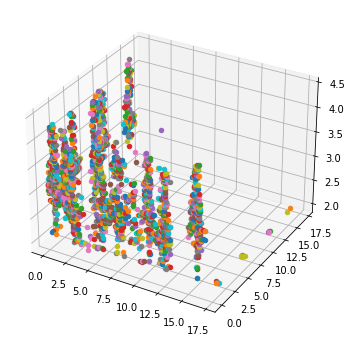

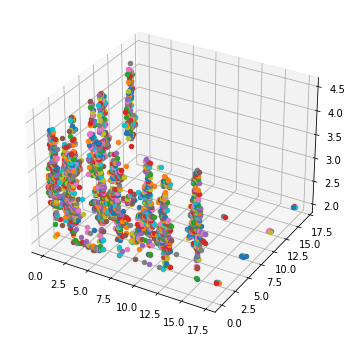

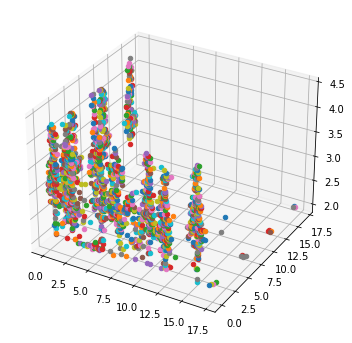

In [121]:
all_startingpoints = {}
for time in app.distanceofWindStreams_index.keys():
    all_startingpoints[time]=[]
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    data = app.timeReasults[time]
    for i in app.distanceofWindStreams_index[time]:

        x = data[i]["y"][0][0]
        y = data[i]["y"][1][0]
        z = data[i]["y"][2][0]
        all_startingpoints[time].append([x,y,z])

        ax.scatter(x, y, z, )
    plt.show()
    

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
%matplotlib inline

15.0
Silhouette Score(n=100): 0.3938573581535767


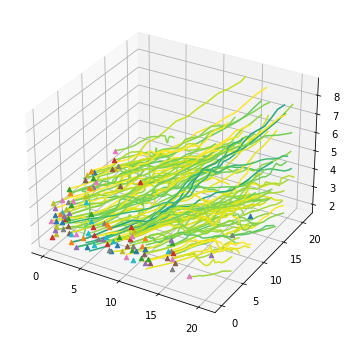

15.5


In [ ]:
for t in all_startingpoints.keys():
    Z=pd.DataFrame(all_startingpoints[t])
    print(t)

    i=100
    KMean= KMeans(n_clusters=i)
    KMean.fit(Z)
    label=KMean.predict(Z)



    print(f'Silhouette Score(n={i}): {silhouette_score(Z, label)}')

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection="3d")
#     ax.scatter3D(Z[0],Z[1],Z[2],c=label/i )
    closest, _ = pairwise_distances_argmin_min(KMean.cluster_centers_, Z)
    data = app.timeReasults[t]
    for c in closest:
        ax.scatter3D(Z[0][c],Z[1][c],Z[2][c],marker='^')


        x = data[c]["y"][0][:]
        y = data[c]["y"][1][:]
        z = data[c]["y"][2][:]
        re = data[c]["re"][:]

        temp =np.max(re)/1600.
        
        ax.plot(x, y, z,  c=cm.viridis(temp))
    
    plt.show()


In [ ]:

for time in app.distanceofWindStreams_index.keys():
    data = self.timeReasults[time]
    maxRE= np.max(np.array(self.__REDict[time]))
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    for i in self.distanceofWindStreams_index[time]:

        x = data[i]["y"][0][:]
        y = data[i]["y"][1][:]
        z = data[i]["y"][2][:]
        re = data[i]["re"][:]

        temp =np.max(re)/maxRE
        ax.plot(x, y, z,  c=cm.viridis(temp))
    plt.show()

### The Reynolds number is defined as

    Re = uL/ν = ρuL/μ 

where:

    ρ is the density of the fluid (SI units: kg/m3)
    u is the flow speed (m/s)
    L is a characteristic linear dimension (m) (see the below sections of this article for examples)
    μ is the dynamic viscosity of the fluid (Pa·s or N·s/m2 or kg/(m·s))
    ν is the kinematic viscosity of the fluid (m2/s).

### The Dynamic viscocity coefficient is defined as

    μ = μo*(a/b)*(T/To)3/2

    a = 0.555To + C
    b = 0.555T + C

where

    μ  = viscosity in centipoise at input temperature T    
    μ0 = reference viscosity in centipoise at reference temperature To 0.01827
    T   = input temperature in degrees Rankine
    T0 = reference temperature in degrees Rankine 524.07
    C  = Sutherland's constant  = 120